## Purpose

Here I will be testing the various pipelines executed for the dippers search using ZTF data.

In [2]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
import astropy.stats as astro_stats

In [778]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [5]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                         "parallax", 
                                                                                         "phot_g_mean_mag"])

CPU times: user 13.2 s, sys: 1.75 s, total: 14.9 s
Wall time: 2min 6s


In [6]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density(131.1, 22.3, gaia_lite)

CPU times: user 515 ms, sys: 120 ms, total: 636 ms
Wall time: 815 ms


{'closest_bright_star_arcsec': 36.39390440082004,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 27.14692435897172,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

In [6]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 12s, sys: 12 s, total: 1min 24s
Wall time: 8min 57s


In [269]:
gaia.head(1)

AttributeError: 'Catalog' object has no attribute 'head'

In [758]:
%%time
# crossmatch ZTF + Gaia - for the sake of speed - let's do a simple cone search.
_all_sky_object = gaia.cone_search(ra=65.884243, dec=34.552133, radius=10).crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5").compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 13.1 s, sys: 3.19 s, total: 16.3 s
Wall time: 1min 35s


In [759]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 81.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2.4 s, sys: 614 ms, total: 3.01 s
Wall time: 5.12 s


In [760]:
%%time
# merge sources to sample hips object
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 7.17 s, sys: 768 ms, total: 7.94 s
Wall time: 7.7 s


In [13]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46213 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46213/status,
Dashboard: http://127.0.0.1:46213/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43690,Workers: 12
Dashboard: http://127.0.0.1:46213/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:46428,Total threads: 8
Dashboard: http://127.0.0.1:44246/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:43327,


In [761]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [762]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 237 ms, sys: 52.6 ms, total: 290 ms
Wall time: 275 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [763]:
_ids = ens.object.head(100).index

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:8260: UserWarning: Insufficient elements for `head`. 100 elements requested, only 87 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [765]:
len(_ids)

87

## Search the most promising candidates

In [766]:
from tqdm import tqdm

In [767]:
_ids

Index([240223430874497024, 240223696730456064, 240233765895405568,
       240235304110260224, 240235687251542016, 240261297420107776,
       240262157046906880, 240263483009007616, 240264424558952448,
       240271430246203392, 240300422223364096, 240308656053157888,
       240309872158048256, 240311809255407616, 240312060125118464,
       240313061397757952, 240319064197562368, 240322490822295552,
       240323677265068032, 240330995981615104, 240331341906837504,
       240334688168706048, 240335572202160128, 240336254787387392,
       240338245274042368, 240348630916005888, 240349929766125568,
       240353799410024448, 240355401445408768, 240357423955574784,
       240360506496385024, 240364536098455552, 240365843135856640,
       240368944295182336, 240369507296608256, 240371537138417664,
       240374035450429440, 240375551540330496, 240377578618093568,
       240687449070632960, 240738779768291328, 240739631887286272,
       240740447541002240, 240747843973808128, 240749979629518

In [791]:
goodid = []
for _id_ in tqdm(_ids[0:25]):
    lc = ens.source.loc[_id_].compute()
    
    print (f"----->{_id_}")
    eva = evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], lc['dec_ztf_source'], 
         gaia_lite, None)
    
    
    print (eva)

  4%|▍         | 1/25 [00:02<00:53,  2.25s/it]

----->240223430874497024
No dip is found within the minimum number of detections.
No peaks found!
None


  8%|▊         | 2/25 [00:04<00:51,  2.25s/it]

----->240223696730456064
No dip is found within the minimum number of detections.
No peaks found!
None
----->240233765895405568


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:319: RuntimeWarning: invalid value encountered in sqrt
  _gpyerr2 = np.sqrt(_gpyerr)
 12%|█▏        | 3/25 [00:43<06:57, 18.97s/it]

0                                              0.010059
1                                              0.021739
2                                                     1
3                                              0.000656
4         0    3.265469
Name: dip_power, dtype: float64
5       0    59392.47869
Name: peak_loc, dtype: float64
6     0    59393.47809
Name: window_start, dtype: fl...
7     0    59316.13485
Name: window_end, dtype: float64
8     0    3.682787
Name: average_dt_dif, dtype: flo...
9              0    22.0
Name: N_in_dip, dtype: float64
10                                         -3233.153107
11                                                  0.0
12                                             0.007434
13                                                  NaN
14                                           200.283492
15                                           117.767641
16                                             8.315343
17                                         59347

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
 16%|█▌        | 4/25 [02:59<22:50, 65.26s/it]

0                                              0.011948
1                                              0.028261
2                                                     1
3                                              0.000656
4         0    5.534931
Name: dip_power, dtype: float64
5       0    58786.38586
Name: peak_loc, dtype: float64
6     0    58786.4152
Name: window_start, dtype: flo...
7     0    58786.38115
Name: window_end, dtype: float64
8     0    0.003254
Name: average_dt_dif, dtype: flo...
9               0    9.0
Name: N_in_dip, dtype: float64
10                                            -2.333545
11                                                  0.0
12                                             0.002276
13                                            11.048501
14                                           594.697642
15                                            16.163912
16                                           795.976037
17                                         58786

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:344: RuntimeWarning: divide by zero encountered in divide
  "log_sum_error": np.log10(sum(_gpy/_gpyerr2**2)),
 20%|██        | 5/25 [03:38<1

0                                              0.010865
1                                              0.018478
2                                                     1
3                                              0.000656
4         0    5.512481
Name: dip_power, dtype: float64
5        0    59306.1366
Name: peak_loc, dtype: float64
6     0    59307.14193
Name: window_start, dtype: fl...
7     0    59294.19259
Name: window_end, dtype: float64
8     0    1.830088
Name: average_dt_dif, dtype: flo...
9               0    7.0
Name: N_in_dip, dtype: float64
10                                           3192.54683
11                                                  0.0
12                                             0.002071
13                                                  inf
14                                            87.037244
15                                          5520.002843
16                                           491.140386
17                                         59294

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in multiply
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
 24%|██▍       | 6/25 [04:11<15:11, 47.96s/it]

0                                              0.013093
1                                              0.024499
2                                                     1
3                                              0.000656
4         0    3.819559
Name: dip_power, dtype: float64
5       0    59395.47281
Name: peak_loc, dtype: float64
6     0    59397.47199
Name: window_start, dtype: fl...
7     0    59394.47203
Name: window_end, dtype: float64
8     0    0.250521
Name: average_dt_dif, dtype: flo...
9               0    9.0
Name: N_in_dip, dtype: float64
10                                            33.867608
11                                                  0.0
12                                             0.001575
13                                             8.139293
14                                           113.094926
15                                            16.246722
16                                             0.849048
17                                         59398

 28%|██▊       | 7/25 [04:13<09:52, 32.94s/it]

----->240262157046906880
No dip is found within the minimum number of detections.
No peaks found!
None


 32%|███▏      | 8/25 [04:15<06:31, 23.03s/it]

----->240263483009007616
No dip is found within the minimum number of detections.
No peaks found!
None


 36%|███▌      | 9/25 [04:17<04:23, 16.47s/it]

----->240264424558952448
No dip is found within the minimum number of detections.
No peaks found!
None
----->240271430246203392


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/george/modeling.py:173: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  setattr(self, k, float(val))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py", line 82, in lnprob2_new
    return gp.log_likelihood(Y, quiet=True) + gp.log_prior()
  File "/epyc/users/atzanida/anaconda3/en

emcee: Exception while calling your likelihood function:
  params: [ 1.55538019e+01  5.90319973e+04  9.00604070e+02  2.27942027e+04
 -8.73281762e+03  4.26042273e+04]
  args: []
  kwargs: {}
  exception:


TypeError: 'NoneType' object is not subscriptable

In [792]:
%%time
lc = ens.source.loc[240235687251542016].compute()

CPU times: user 589 ms, sys: 148 ms, total: 738 ms
Wall time: 2.32 s


### Example Source

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


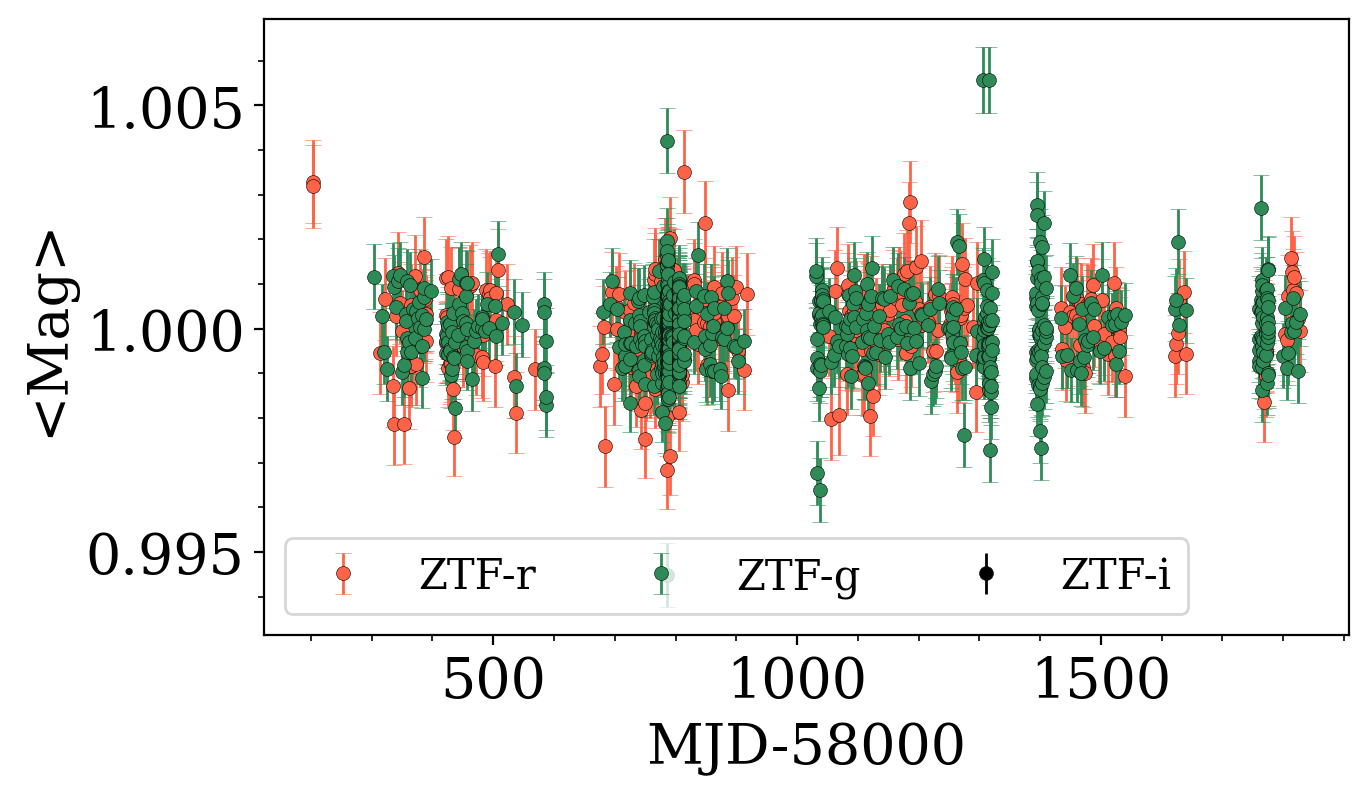

In [793]:
# gri light curves

flts = list('gri')
clrs = ['tomato', 'seagreen', 'k']
label=['ZTF-r', 'ZTF-g', 'ZTF-i']

plt.figure(figsize=(7, 4))
for a, b, c in zip(flts, clrs, label):

    time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                       lc['mag_ztf_source'], 
                       lc['magerr_ztf_source'], 
                       lc['catflags_ztf_source'],
                       lc['band_ztf_source'], band_of_study=a, flag_good=0)
    
    plt.errorbar(time-58_000, mag/np.median(mag), magerr/np.median(mag), fmt='.', color=b, mec='k', mew=0.2, lw=1, 
                label=c, ms=10, capsize=3)
    plt.minorticks_on()
    plt.xlabel("MJD-58000")
    plt.ylabel('<Mag>')

  
plt.legend(ncols=3, fontsize=15)

(15.852786110993474, 15.635761310998351)

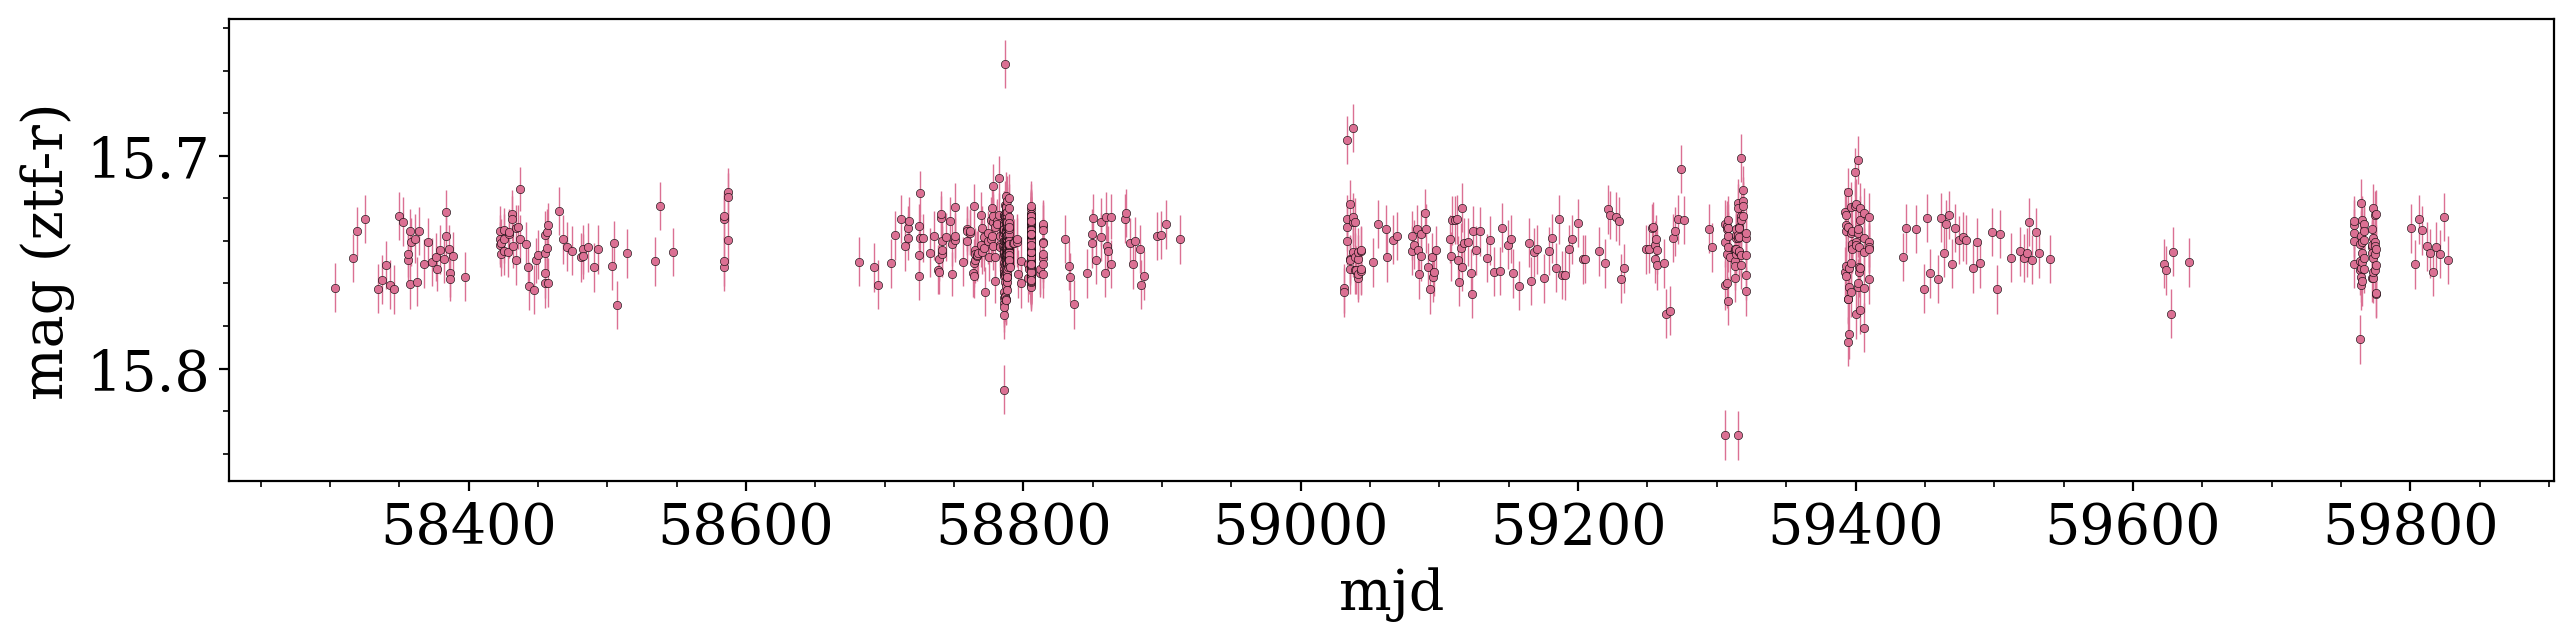

In [807]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

plt.figure(figsize=(15, 3))
plt.errorbar(time, mag, magerr, fmt='.', color='palevioletred', mec='k', mew=0.2, lw=0.5)
plt.minorticks_on()
plt.xlabel("mjd")
plt.ylabel('mag (ztf-r)')
plt.ylim(plt.ylim()[::-1])

In [811]:
time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=25, max_gap_days=95)

<ErrorbarContainer object of 3 artists>

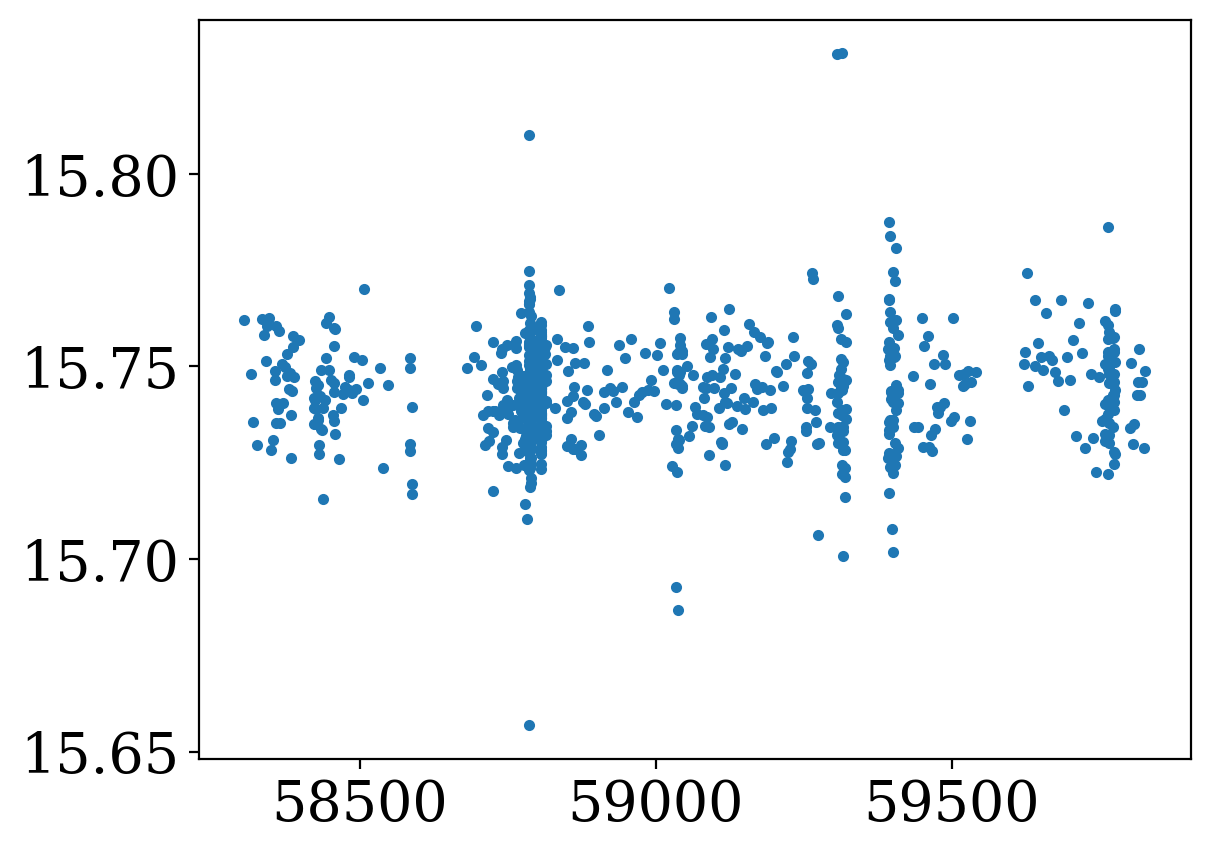

In [813]:
plt.errorbar(time, mag, fmt='.')


In [814]:
f = dip_models.ggd(time, np.median(time) + np.random.randint(0, 250), 3, 3, 15, 4) + \
dip_models.ggd(time, np.median(time)-350, 30, 3, 1, 7) + \
np.random.normal(0, 1.5*np.std(mag), len(time)) 

Text(0.5, 1.0, 'Synthetic example')

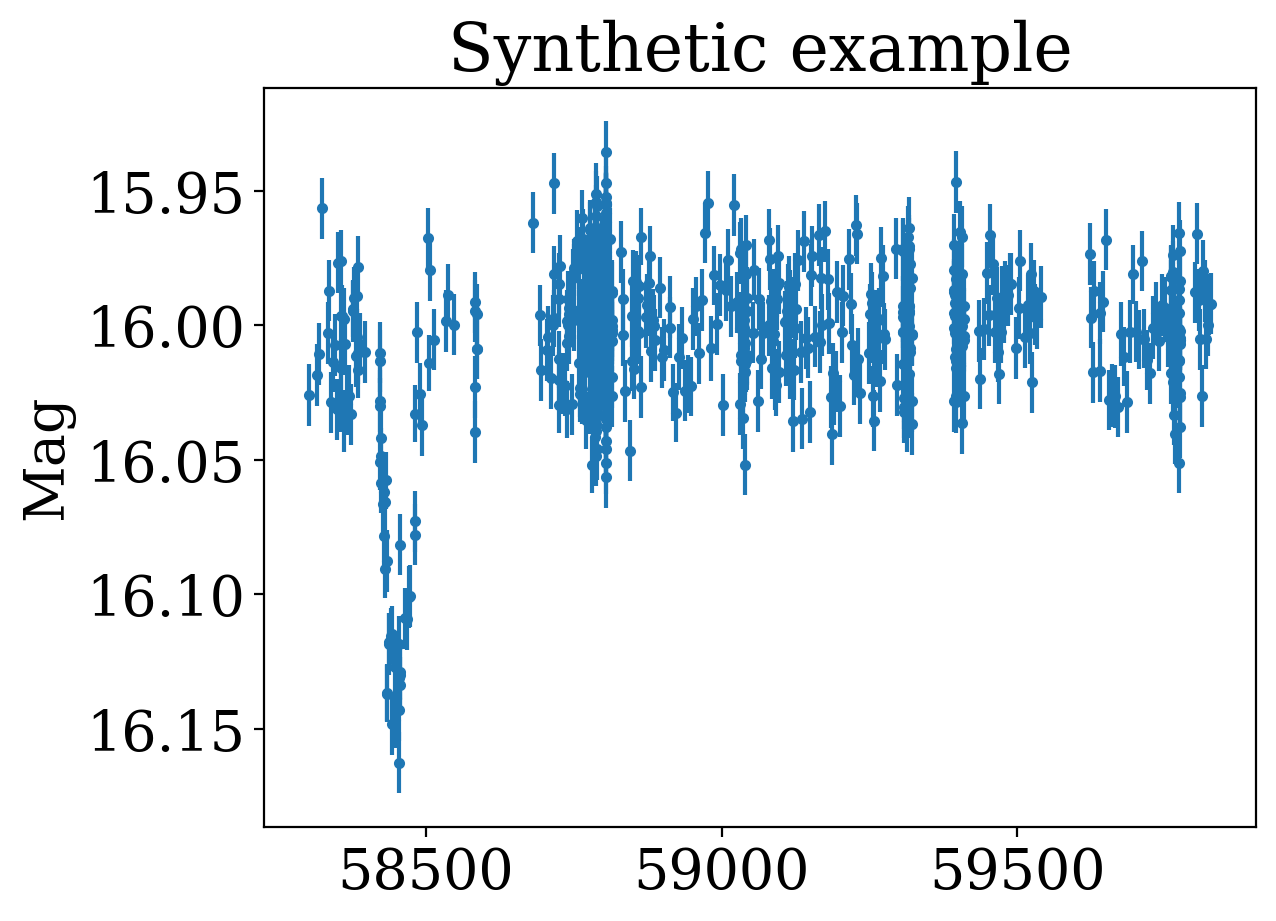

In [815]:
plt.errorbar(time, f, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])
plt.ylabel("Mag")
plt.title("Synthetic example")

In [816]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

Text(0, 0.5, '(m-R)/($\\sigma^2$+S$^{2}$)$^{0.5}$')

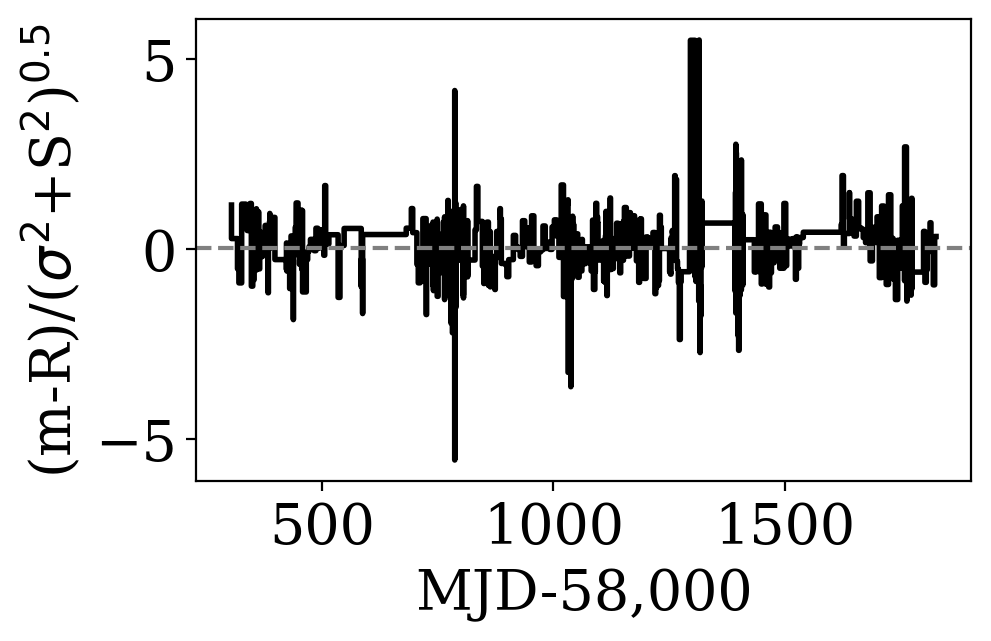

In [817]:
plt.figure(figsize=(5,3))
plt.step(time-58_000, running_deviation, color='k', lw=2)
plt.axhline(np.median(running_deviation), ls='--', color='gray')
plt.xlabel("MJD-58,000")
plt.ylabel("(m-R)/($\sigma^2$+S$^{2}$)$^{0.5}$")

In [818]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=1.5,  peak_close_rmv=15, pk_2_pk_cut=30)

# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

In [820]:
bp

peak_loc            59306.136600
window_start        59307.141930
window_end          59294.192590
N_1sig_in_dip           3.000000
N_in_dip                7.000000
loc_forward_dur         1.005330
loc_backward_dur       11.944010
dip_power               5.494724
average_dt_dif          1.830088
Name: 3, dtype: float64

(59171.1366, 59441.1366)

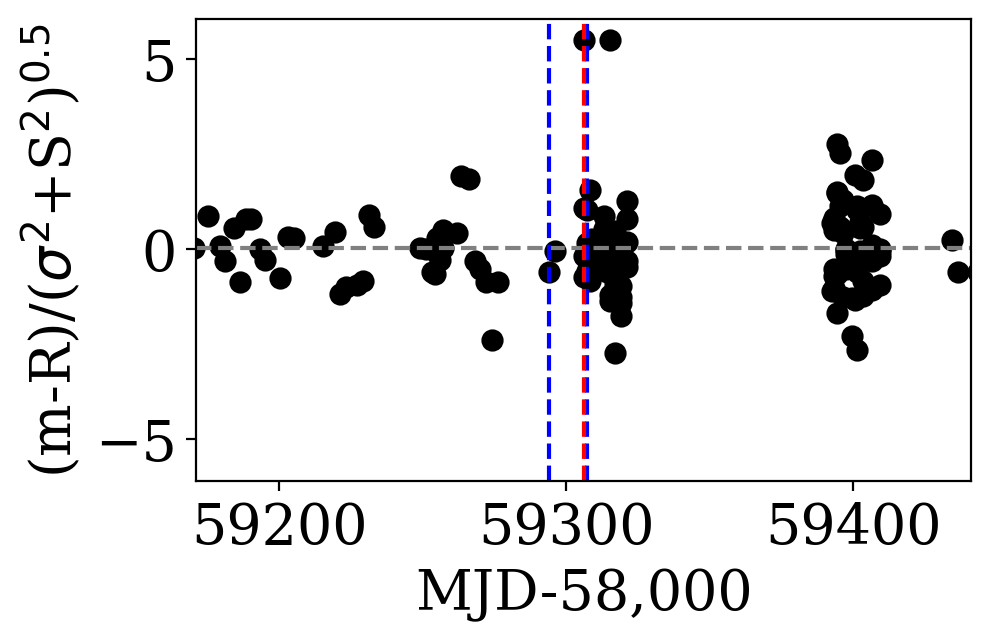

In [819]:
plt.figure(figsize=(5,3))
plt.scatter(time, running_deviation, color='k', lw=2)
plt.axhline(np.median(running_deviation), ls='--', color='gray')
plt.xlabel("MJD-58,000")
plt.ylabel("(m-R)/($\sigma^2$+S$^{2}$)$^{0.5}$")
plt.axvline(bp['window_start'], color='blue', ls='--')
plt.axvline(bp['window_end'], color='blue', ls='--')
plt.axvline(bp['peak_loc'], color='red', ls='--')
plt.xlim(bp['peak_loc']-135, bp['peak_loc']+135)

In [704]:
x, y, yerr = my_tools.digest_the_peak(bp, time, f, magerr, expandby=15)

<ErrorbarContainer object of 3 artists>

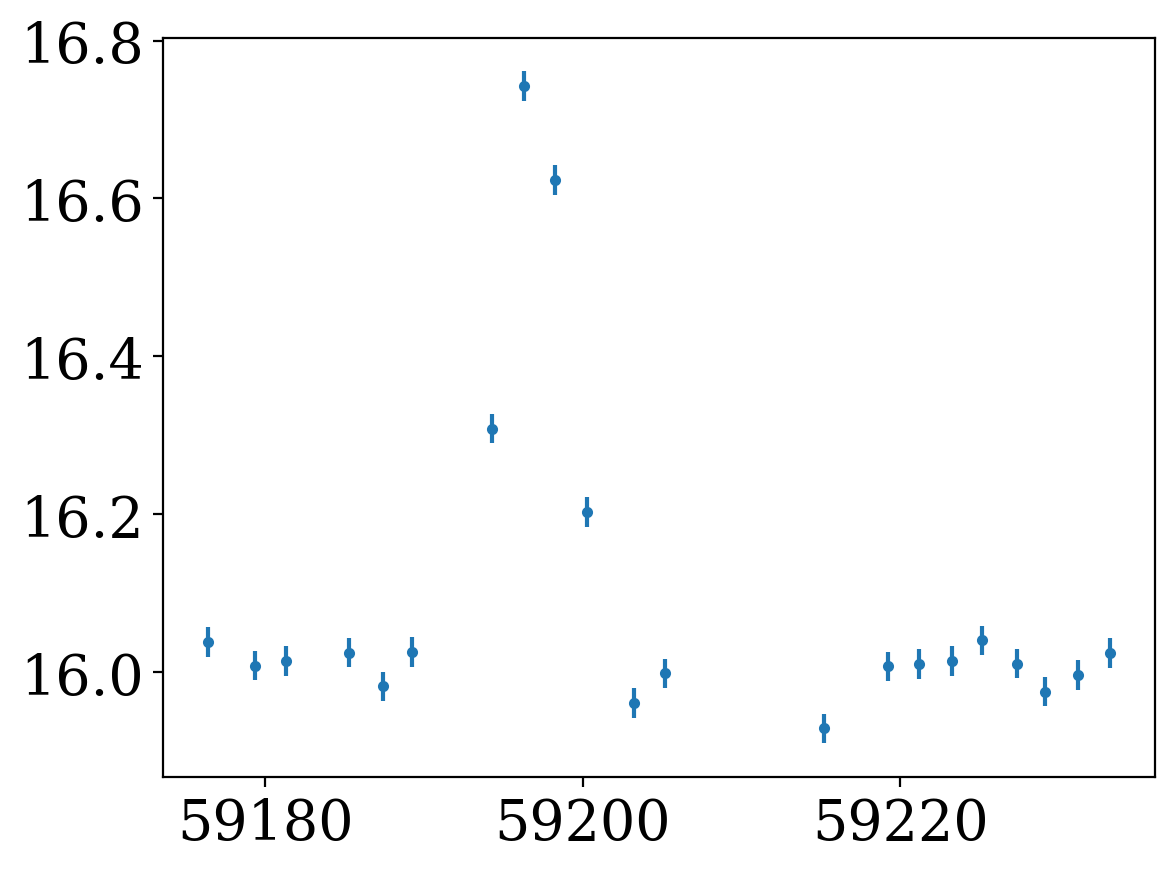

In [705]:
plt.errorbar(x, y, yerr, fmt='.')

In [706]:
astropy_fit = my_tools.quick_Gaussian_fit(time, running_deviation)

In [707]:
astropy_fit

{'amplitude': 17.203455772742004,
 'mean': 59196.926441987314,
 'stddev': 1.988487749990746}

(16.803647047256153, 15.867656697545257)

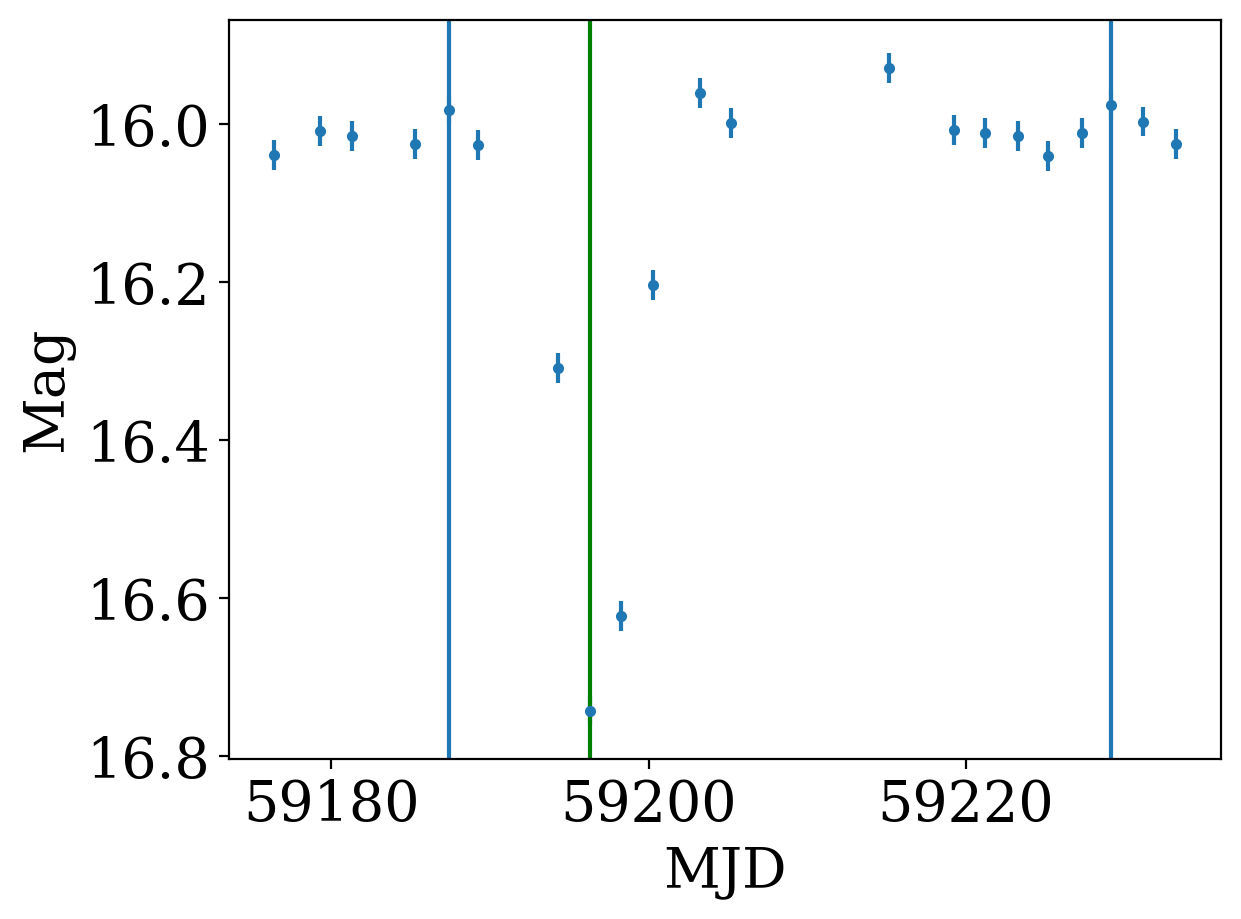

In [708]:
plt.errorbar(x, y, yerr, fmt='.')
plt.axvline(bp['window_start'])
plt.axvline(bp['window_end'])
plt.xlabel("MJD")
plt.ylabel("Mag")
plt.axvline(bp['peak_loc'], color='green')
plt.ylim(plt.ylim()[::-1])

In [709]:
init = dict(amp=astropy_fit['amplitude'],
            location=bp['peak_loc'],
            sigma=astropy_fit['stddev'], log_sigma2=np.log(0.4))

In [776]:
%%time
gp2 = model_gp(x, y, yerr, bp['window_end'],
               bp['window_start'], init)

CPU times: user 24.4 s, sys: 4.54 s, total: 29 s
Wall time: 25.4 s


<ErrorbarContainer object of 3 artists>

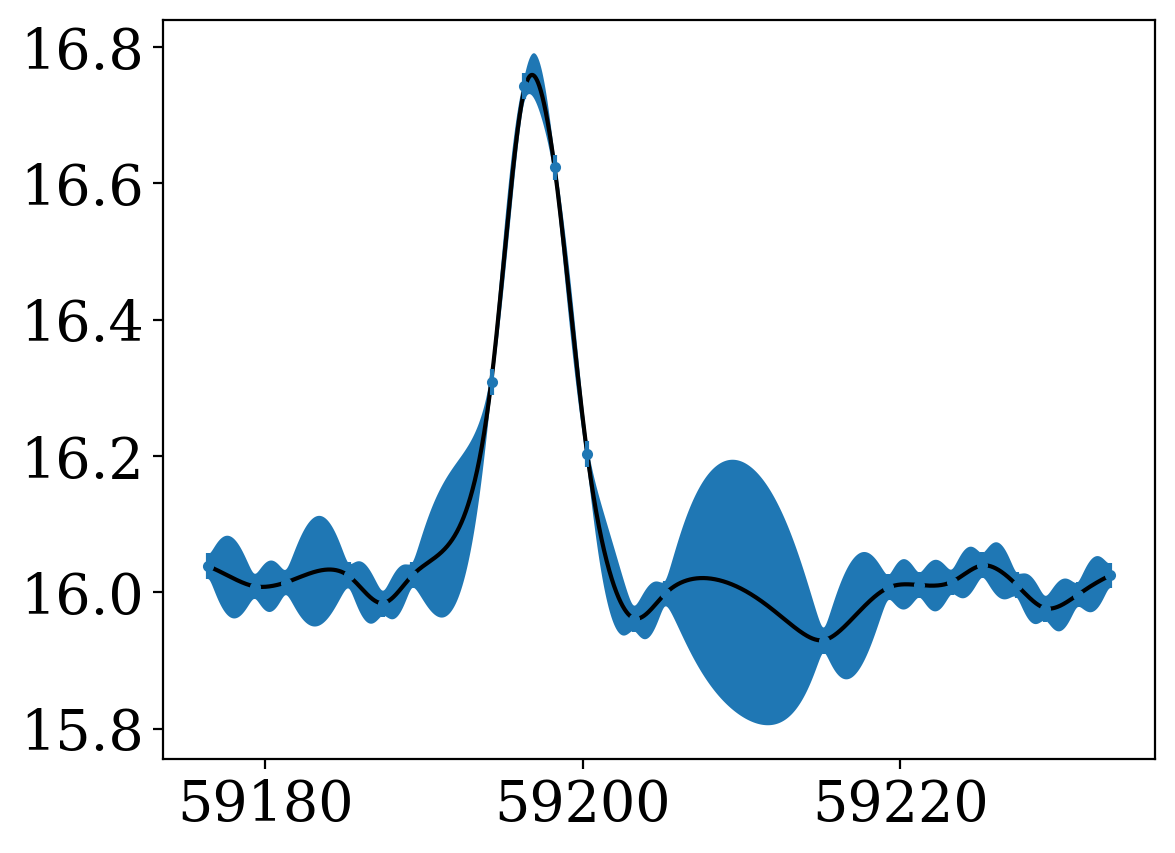

In [712]:
plt.fill_between(gp2[0], gp2[1]-np.sqrt(gp2[2]), gp2[1]+np.sqrt(gp2[2]))
plt.plot(gp2[0], gp2[1], color='k')
plt.errorbar(x, y, yerr, fmt='.')

In [781]:
dip_pipeline.evaluate_dip(gp2, x, y, yerr, R, S, bp['peak_loc'], diagnostic=False)

{'assymetry_score': 14.593975721364174,
 'left_error': 0.009341374005903574,
 'right_error': 0.013015148260514354,
 'log_sum_error': 7.882571551689007,
 'log-like': 11.970671090203368,
 'amp_median': 16.055438686066008,
 'amp_std': 0.2444310046174736,
 'location_median': 59212.49416156368,
 'location_std': 19.52096268507002,
 'sigma_median': 100.20365034357857,
 'sigma_std': 303.98964254773017,
 'log_sigma2_median': 1253.0258854464962,
 'log_sigma2_std': 141239.42349010275,
 'm_median': -2.9944199050953166,
 'm_std': 0.7753492147925877,
 'b_median': 2.878220355439336,
 'b_std': 0.838270742766338,
 'separation_btw_peaks': 0.5267976095201448}

In [738]:
gp = dip_pipeline.GaussianProcess_dip(x, y, yerr, length_scale=0.01)

In [739]:
gp[-1]

{'init_log_L': 0,
 'final_log_L': 0,
 'success_status': True,
 'chi-square': 0.8213702778147723}

<ErrorbarContainer object of 3 artists>

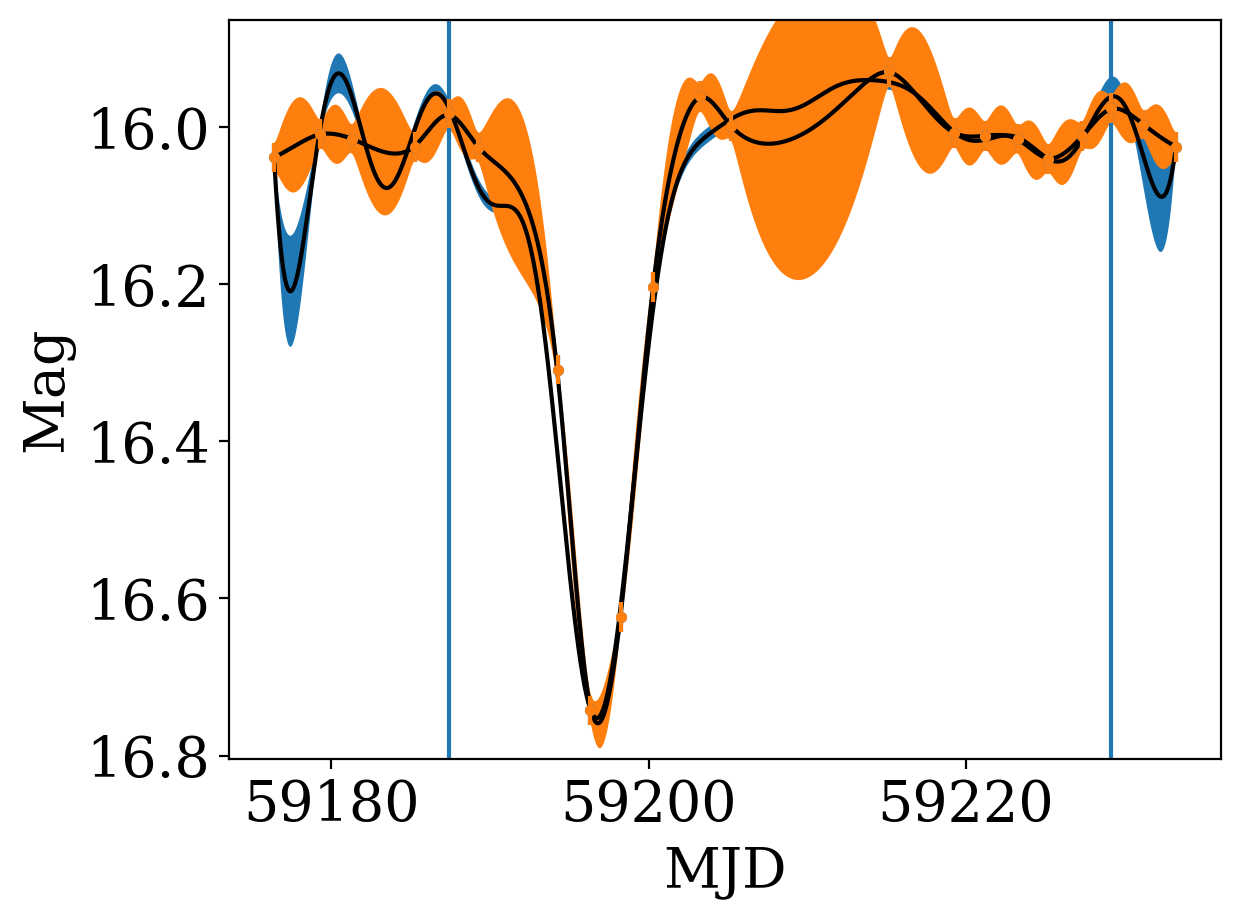

In [741]:
plt.fill_between(gp[0], gp[1]-gp[2], gp[1]+gp[2])
plt.plot(gp[0], gp[1], color='k')
plt.errorbar(x, y, yerr, fmt='.')
plt.ylim(plt.ylim()[::-1])
plt.axvline(bp['window_start'])
plt.axvline(bp['window_end'])
plt.xlabel("MJD")
plt.ylabel("Mag")

plt.fill_between(gp2[0], gp2[1]-np.sqrt(gp2[2]), gp2[1]+np.sqrt(gp2[2]))
plt.plot(gp2[0], gp2[1], color='k')
plt.errorbar(x, y, yerr, fmt='.')

In [944]:
variable_names = [
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'best_dip_power',
    'best_dip_time',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_integral_score',
    'chi-square-gp',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']


In [752]:
evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source']-180, lc['dec_ztf_source'], 
         gaia_lite, None)

No dip is found within the minimum number of detections.
No peaks found!


## Synthetic Dip Example

In [2314]:
min(time), max(time)

(58288.46224, 59828.45702)

In [2315]:
time = np.linspace(58288.47665, 59829.44453, 250) + np.random.normal(2, 40000, 250)
time = time[np.argsort(time)]
model = dip_models.skew_norm(time, np.median(time)+330, 600, 0, 16, 0.5) + np.random.normal(0, 0.01, len(time))
model_err = np.random.normal(np.mean(magerr), np.std(magerr), 250)

<ErrorbarContainer object of 3 artists>

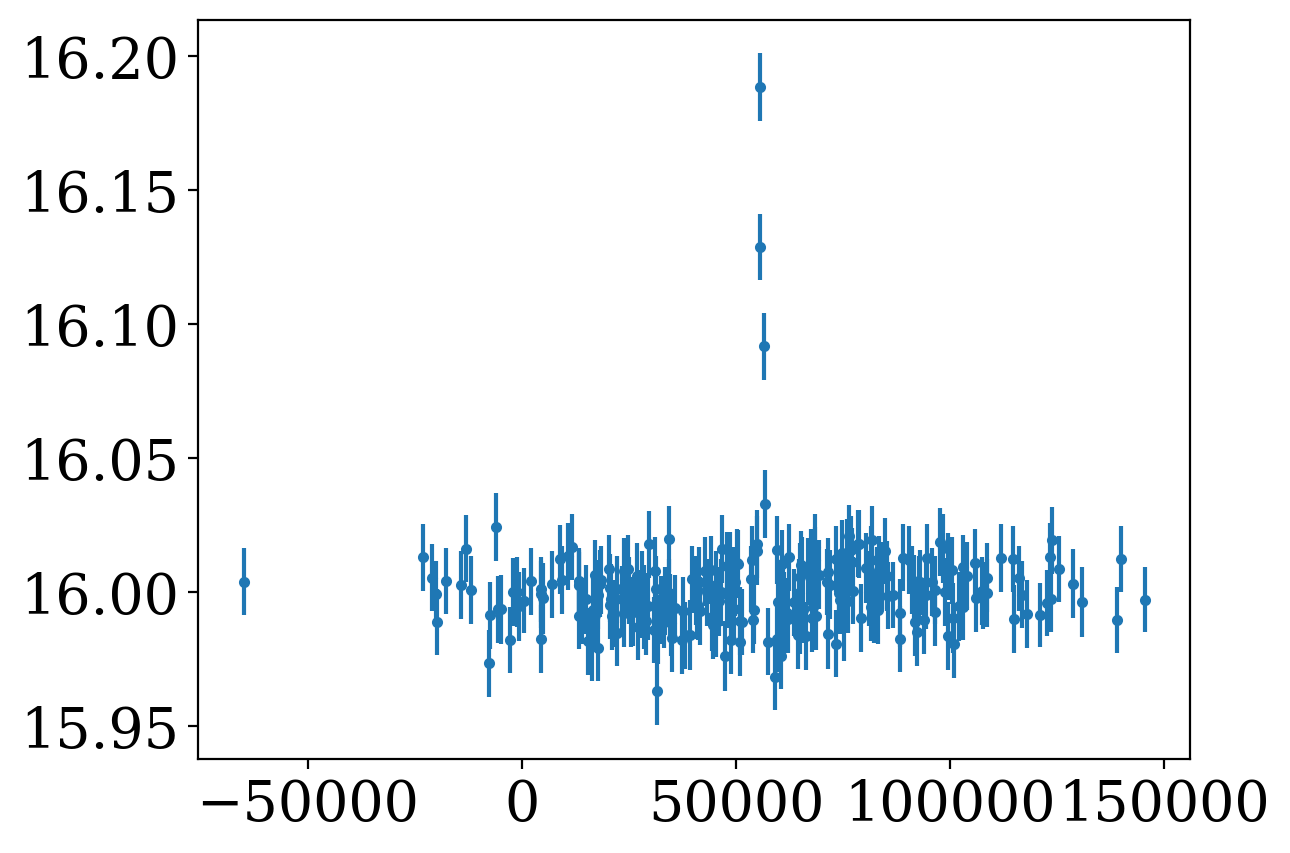

In [2316]:
plt.errorbar(time, model, model_err, fmt='.')

In [2317]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)

# Running deviation
running_deviation = dip_pipeline.deviation(model, model_err, R, S)

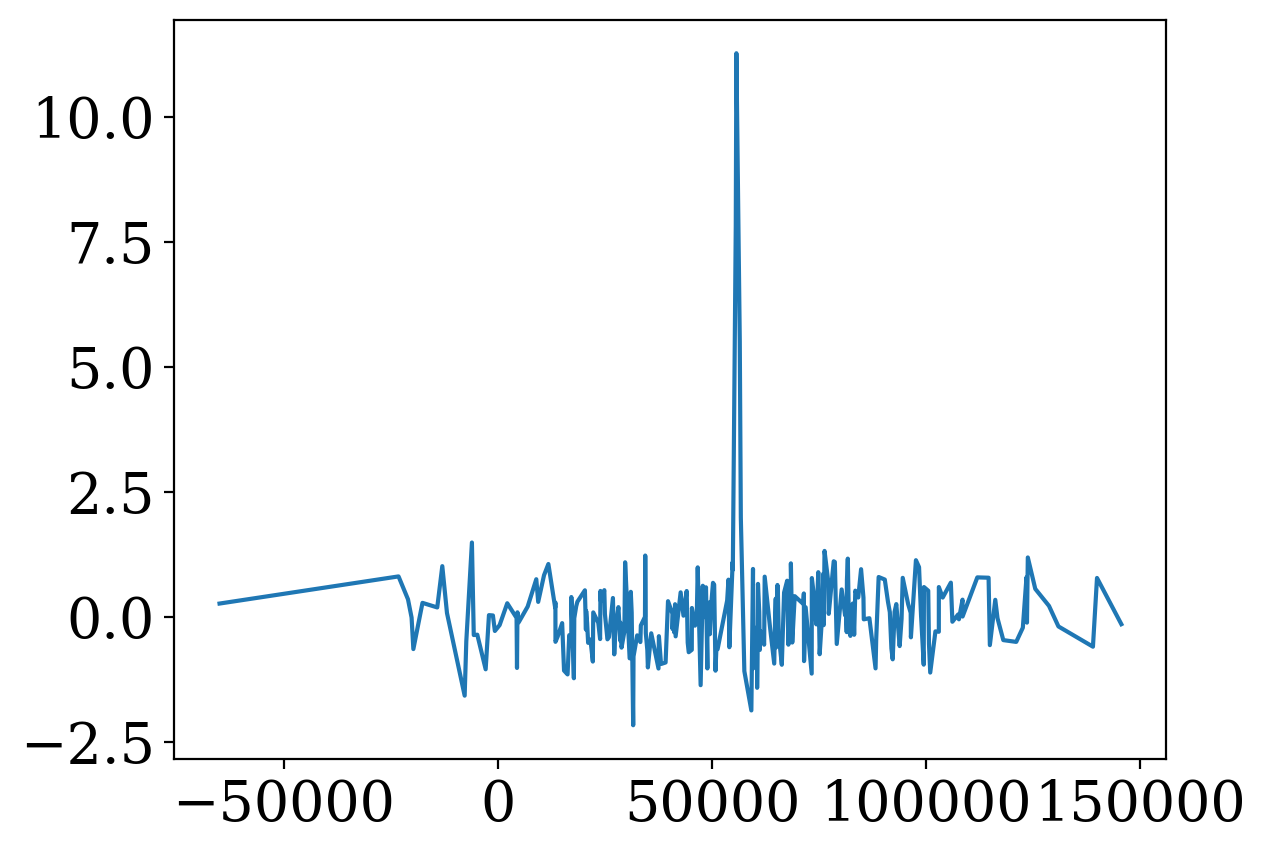

In [2318]:
plt.plot(time, running_deviation)

In [2319]:
t_init = models.Gaussian1D(amplitude=50., mean=time[np.argmax(running_deviation)]-1, stddev=0.2, 
                          bounds={"amplitude": (3, max(running_deviation)), 
                                 "mean": (time[np.argmax(running_deviation)]-535,
                                          time[np.argmax(running_deviation)]+535), 
                                 "stddev": (0.1, 1_000)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, time, running_deviation, maxiter=2_000)

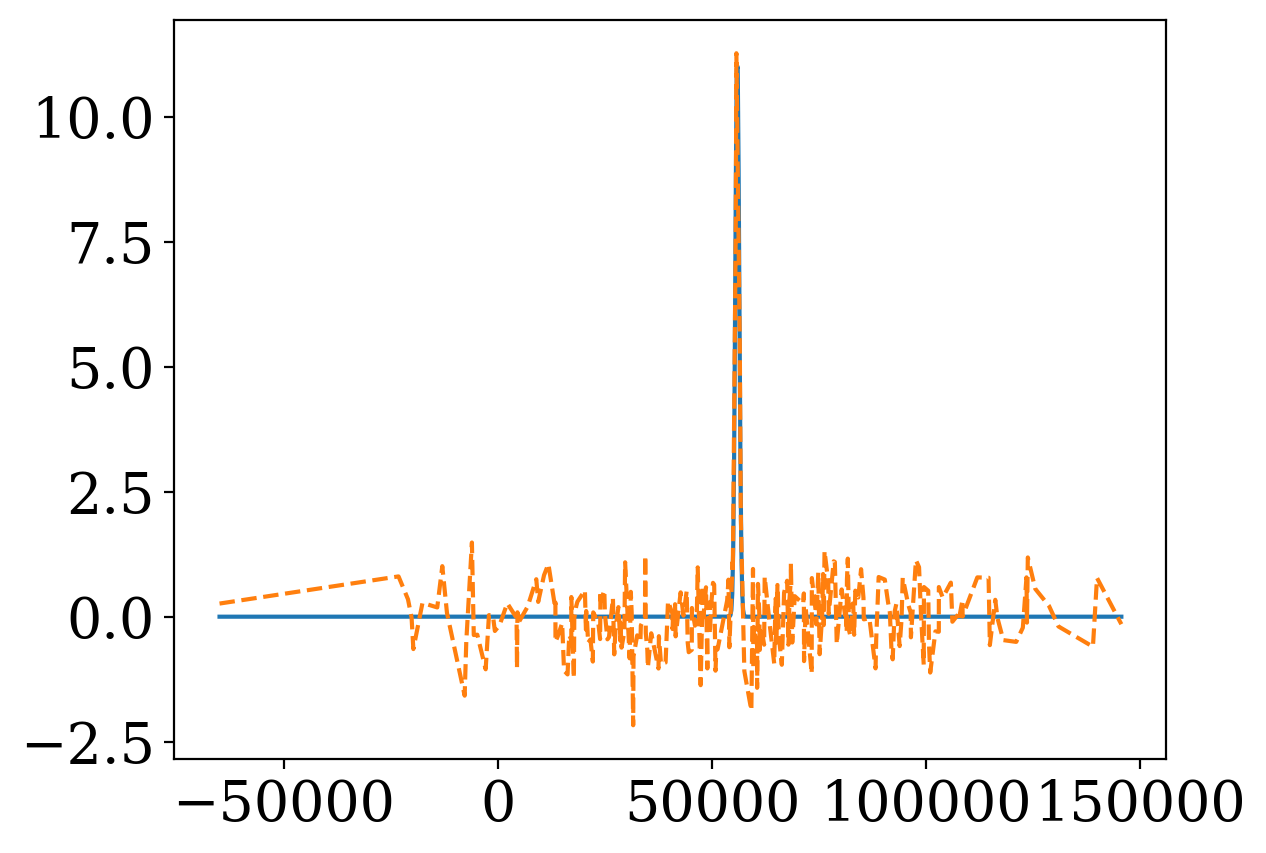

In [2320]:
bb = np.linspace(min(time), max(time), 1000)
plt.plot(bb, t(bb))
plt.plot(time, running_deviation, ls='--')

In [2321]:
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=3, peak_close_rmv=15, pk_2_pk_cut=30)

In [2322]:
peak_detections

(1,
 {'dip_0': {'peak_loc': 55675.248783692776,
   'window_start': 61225.98350846764,
   'window_end': 54842.99991123906,
   'N_1sig_in_dip': 4,
   'N_in_dip': 14,
   'loc_forward_dur': 5550.734724774862,
   'loc_backward_dur': 832.2488724537179,
   'dip_power': 11.270268585995659,
   'average_dt_dif': 431.9861505238889}})

In [2323]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=3, peak_close_rmv=15, pk_2_pk_cut=30)


In [2324]:
peak_detections

(1,
 {'dip_0': {'peak_loc': 55675.248783692776,
   'window_start': 61225.98350846764,
   'window_end': 54842.99991123906,
   'N_1sig_in_dip': 4,
   'N_in_dip': 14,
   'loc_forward_dur': 5550.734724774862,
   'loc_backward_dur': 832.2488724537179,
   'dip_power': 11.270268585995659,
   'average_dt_dif': 431.9861505238889}})

In [2325]:
# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=3)

In [2340]:
x, y, yerr = my_tools.digest_the_peak(bp, time, model, model_err, expandby=3)

In [2341]:
astropy_fit = my_tools.quick_Gaussian_fit(time, running_deviation)

In [2342]:
%%time
init = dict(amp=t.amplitude.value,
            location=bp['peak_loc'],
            sigma=t.stddev.value, log_sigma2=np.log(0.4))
gp2 = model_gp(x, y, yerr, bp['window_end'].values[0], bp['window_start'].values[0], init, ell=1)

CPU times: user 25.6 s, sys: 5.2 s, total: 30.8 s
Wall time: 25.4 s


In [2344]:
gp2

(array([54842.99991124, 54844.27676333, 54845.55361542, ...,
        61223.42980429, 61224.70665638, 61225.98350847]),
 array([16.01664664, 16.01674969, 16.01685327, ..., 15.99263287,
        15.99262208, 15.99261152]),
 array([1.57929009e-04, 1.57695999e-04, 1.57530973e-04, ...,
        9.95644546e-05, 1.00955837e-04, 1.02385982e-04]),
 {'log-like': 29.525352374961326,
  'amp_median': 16.01588079018771,
  'amp_std': 0.5748082819373818,
  'location_median': 55777.91332932406,
  'location_std': 1670.97336626931,
  'sigma_median': 530.8951453788736,
  'sigma_std': 267.301879465984,
  'log_sigma2_median': 2356.364744541903,
  'log_sigma2_std': 195296.7652114766,
  'm_median': -5.061204790871286,
  'm_std': 2.0646563225580357,
  'b_median': 13.464353309584038,
  'b_std': 112.4984664783421})

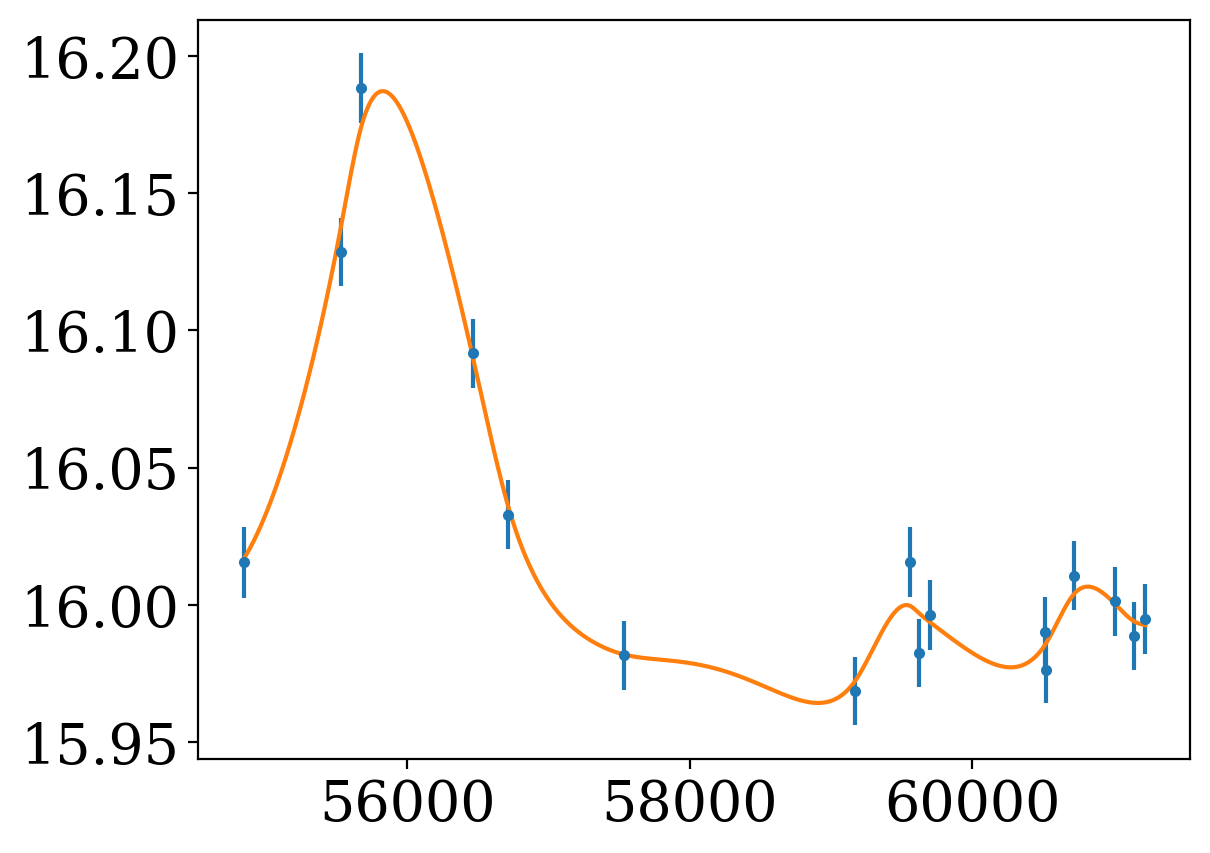

In [2343]:
plt.errorbar(x, y, yerr, fmt='.')
plt.plot(gp2[0], gp2[1])


In [990]:
a, b, c = np.percentile(y, [25, 50, 75])

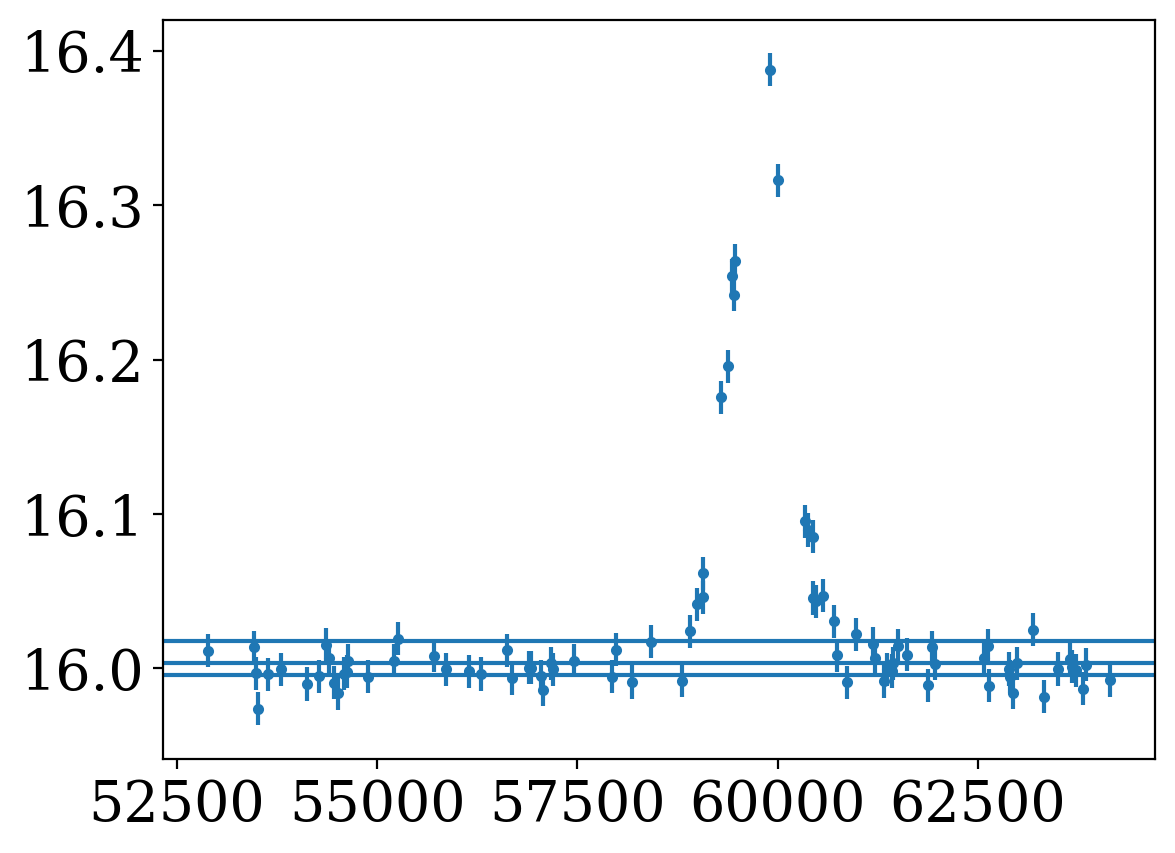

In [992]:
plt.errorbar(x, y, yerr, fmt='.')
plt.axhline(a)
plt.axhline(b)
plt.axhline(c)

In [993]:
gp = dip_pipeline.GaussianProcess_dip(x, y, yerr, length_scale=0.01)

In [994]:
gp

(array([52891.92248458, 52897.55429833, 52903.18611208, ...,
        64138.65454576, 64144.28635952, 64149.91817327]),
 array([16.01069938, 16.01083711, 16.01097392, ..., 15.99244211,
        15.99162674, 15.9907655 ]),
 array([0.00524242, 0.00496456, 0.00472623, ..., 0.00473491, 0.00497365,
        0.00525194]),
 {'init_log_L': 0,
  'final_log_L': 0,
  'success_status': True,
  'chi-square': 198.35117090023957})

<ErrorbarContainer object of 3 artists>

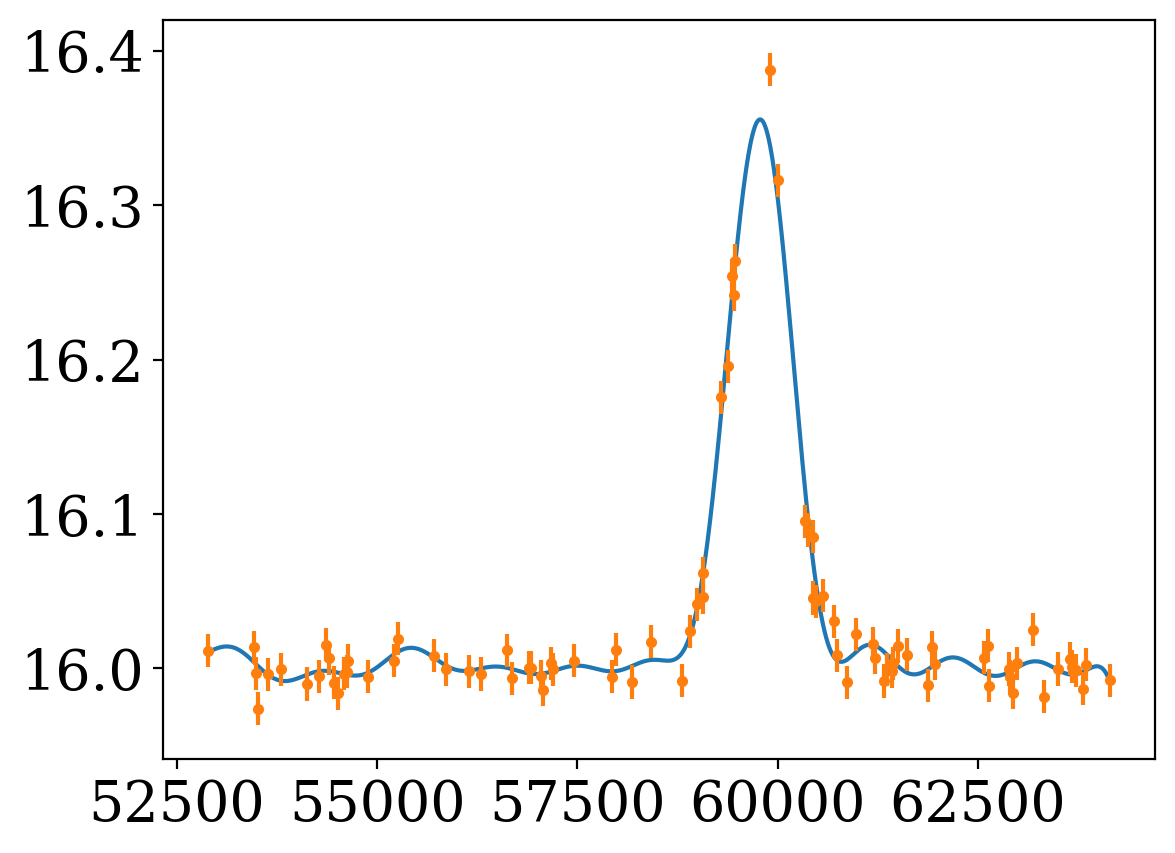

In [995]:
plt.plot(gp[0], gp[1])
plt.errorbar(x, y, yerr, fmt='.')

In [655]:
from tqdm import tqdm
for _id in tqdm(ens.object.head(50).index):
    lc = ens.source.loc[_id].compute()
    print (f'Now computing.... {_id}')
    result = evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], lc['dec_ztf_source'], 
         gaia_lite, None)

  0%|          | 0/50 [00:00<?, ?it/s]

Now computing.... 6124190825120268288


  2%|▏         | 1/50 [00:04<03:56,  4.83s/it]

No peaks found!


  4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

Now computing.... 6124191013062836224
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124191246257750016


  6%|▌         | 3/50 [00:12<03:27,  4.41s/it]

Now computing.... 6124191326687723520


  8%|▊         | 4/50 [00:20<04:21,  5.69s/it]

Now computing.... 6124284960145670144


 10%|█         | 5/50 [00:30<05:34,  7.43s/it]

Now computing.... 6124285425998626816


 12%|█▏        | 6/50 [00:39<05:46,  7.87s/it]

No peaks found!
Now computing.... 6124285419317100544


 14%|█▍        | 7/50 [00:45<05:10,  7.23s/it]

Now computing.... 6124285541832720384


 16%|█▌        | 8/50 [00:51<04:50,  6.91s/it]

Now computing.... 6124285644991627264


 18%|█▊        | 9/50 [00:57<04:24,  6.45s/it]

Now computing.... 6124285923505995776


 20%|██        | 10/50 [01:03<04:20,  6.52s/it]

Now computing.... 6124286525535420416


 22%|██▏       | 11/50 [01:11<04:33,  7.01s/it]

Now computing.... 6124286607005581312


 24%|██▍       | 12/50 [01:18<04:22,  6.90s/it]

Now computing.... 6124286802434981888


 26%|██▌       | 13/50 [01:26<04:26,  7.19s/it]

Now computing.... 6124286935755128832


 28%|██▊       | 14/50 [01:34<04:25,  7.37s/it]

Now computing.... 6124287411426951168


 30%|███       | 15/50 [01:40<04:08,  7.10s/it]

Now computing.... 6124290044212543488


 32%|███▏      | 16/50 [01:53<04:56,  8.72s/it]

Now computing.... 6124290617573900288


 36%|███▌      | 18/50 [02:02<03:29,  6.56s/it]

Now computing.... 6124292181415952384
No dip is found within the minimum number of detections.
No peaks found!


 38%|███▊      | 19/50 [02:05<02:49,  5.48s/it]

Now computing.... 6124292340153581568
GP failed!
No peaks found!


 40%|████      | 20/50 [02:09<02:25,  4.86s/it]

Now computing.... 6124292744090222592
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124293136689659904


 42%|████▏     | 21/50 [02:16<02:44,  5.66s/it]

Now computing.... 6124293852284059648


 46%|████▌     | 23/50 [02:26<02:17,  5.10s/it]

Now computing.... 6124295724847857664
GP failed!
No peaks found!


 48%|████▊     | 24/50 [02:29<01:55,  4.43s/it]

Now computing.... 6124707728905469952
No dip is found within the minimum number of detections.
No peaks found!


 50%|█████     | 25/50 [02:32<01:40,  4.02s/it]

Now computing.... 6124708078114832384
GP failed!
No peaks found!


 52%|█████▏    | 26/50 [02:35<01:30,  3.76s/it]

Now computing.... 6124708528549527552
No dip is found within the minimum number of detections.
No peaks found!


 54%|█████▍    | 27/50 [02:38<01:25,  3.74s/it]

Now computing.... 6124709507495886848
No dip is found within the minimum number of detections.
No peaks found!


 56%|█████▌    | 28/50 [02:41<01:17,  3.52s/it]

Now computing.... 6124709476399316992
No dip is found within the minimum number of detections.
No peaks found!


 58%|█████▊    | 29/50 [02:44<01:10,  3.36s/it]

Now computing.... 6124709701872517120
No dip is found within the minimum number of detections.
No peaks found!


 60%|██████    | 30/50 [02:47<01:03,  3.20s/it]

Now computing.... 6124709843795181568
GP failed!
No peaks found!


 62%|██████▏   | 31/50 [02:50<00:58,  3.08s/it]

Now computing.... 6124712401217519616
No dip is found within the minimum number of detections.
No peaks found!


 64%|██████▍   | 32/50 [02:53<00:55,  3.07s/it]

Now computing.... 6124715116119195648
GP failed!
No peaks found!


 66%|██████▌   | 33/50 [02:56<00:51,  3.04s/it]

Now computing.... 6124716157652959232
No dip is found within the minimum number of detections.
No peaks found!


 68%|██████▊   | 34/50 [02:59<00:48,  3.02s/it]

Now computing.... 6124716768846938112
No dip is found within the minimum number of detections.
No peaks found!


 70%|███████   | 35/50 [03:02<00:43,  2.92s/it]

Now computing.... 6124717096719876096
GP failed!
No peaks found!


 72%|███████▏  | 36/50 [03:05<00:40,  2.91s/it]

Now computing.... 6124718374648807424
No dip is found within the minimum number of detections.
No peaks found!


 74%|███████▍  | 37/50 [03:08<00:38,  2.98s/it]

Now computing.... 6124718685740335104
GP failed!
No peaks found!


 76%|███████▌  | 38/50 [03:10<00:34,  2.89s/it]

Now computing.... 6124719155087147008
No dip is found within the minimum number of detections.
No peaks found!


 78%|███████▊  | 39/50 [03:13<00:31,  2.83s/it]

Now computing.... 6124719372763136000
No dip is found within the minimum number of detections.
No peaks found!


 80%|████████  | 40/50 [03:17<00:30,  3.10s/it]

Now computing.... 6124719522814361600
No dip is found within the minimum number of detections.
No peaks found!


 82%|████████▏ | 41/50 [03:20<00:27,  3.11s/it]

Now computing.... 6124738501628919808
No dip is found within the minimum number of detections.
No peaks found!


 84%|████████▍ | 42/50 [03:23<00:25,  3.13s/it]

Now computing.... 6124739361608040448
No dip is found within the minimum number of detections.
No peaks found!


 86%|████████▌ | 43/50 [03:26<00:21,  3.13s/it]

Now computing.... 6124740976058564608
No dip is found within the minimum number of detections.
No peaks found!


 88%|████████▊ | 44/50 [03:29<00:18,  3.03s/it]

Now computing.... 6124742375249018880
No dip is found within the minimum number of detections.
No peaks found!


 90%|█████████ | 45/50 [03:33<00:15,  3.13s/it]

Now computing.... 6124742738660294656
No dip is found within the minimum number of detections.
No peaks found!


 92%|█████████▏| 46/50 [03:35<00:12,  3.09s/it]

Now computing.... 6124743056034889728
No dip is found within the minimum number of detections.
No peaks found!


 94%|█████████▍| 47/50 [03:39<00:09,  3.09s/it]

Now computing.... 6124743478350970880
GP failed!
No peaks found!


 96%|█████████▌| 48/50 [03:41<00:05,  2.99s/it]

Now computing.... 6124743942748504064
No dip is found within the minimum number of detections.
No peaks found!


 98%|█████████▊| 49/50 [03:45<00:03,  3.07s/it]

Now computing.... 6124744188283060224
GP failed!
No peaks found!


100%|██████████| 50/50 [03:47<00:00,  4.56s/it]

Now computing.... 6124745004846940160
GP failed!
No peaks found!


In [66]:
import matplotlib.pyplot 

In [67]:
cm = matplotlib.pyplot.get_cmap('RdBu')

In [104]:
xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1) + np.random.normal(0, 0.001, 100)

In [148]:
scr = []
from tqdm import tqdm
for j in tqdm(np.linspace(-5, 5, 30)):
    xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
    yy = dip_models.skew_norm(xx, 0, 2, j, 16, 0.1) + np.random.normal(0, 1e-12, 100)

    gp = dip_pipeline.GaussianProcess_dip(xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), alpha=1, metric=100)

    # GP assesment of quality 
    gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)

    scr.append(gp_quality['assymetry_score'])

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


In [166]:
sk = np.linspace(-3, 3, 10)
sig = np.linspace(0.1, 5, 10)

xx = np.linspace(-15, 15, 50) + np.random.normal(0, 1, 50)
nz = abs(np.random.normal(0, 1e-8, len(xx)))

X, Y = np.meshgrid(sk, sig, indexing='xy')

Master = np.zeros(shape=np.shape(X))

for i in tqdm(range(len(X))):
    for j in range(len(Y)):
        yy = dip_models.skew_norm(xx, 0, sig[j], sk[i], 16, 0.1) 
        gp = dip_pipeline.GaussianProcess_dip(xx, yy, nz, alpha=1, metric=100)

        # GP assesment of quality 
        gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, nz, 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)
        
        Master[i,j] = gp_quality['assymetry_score']
        
        

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


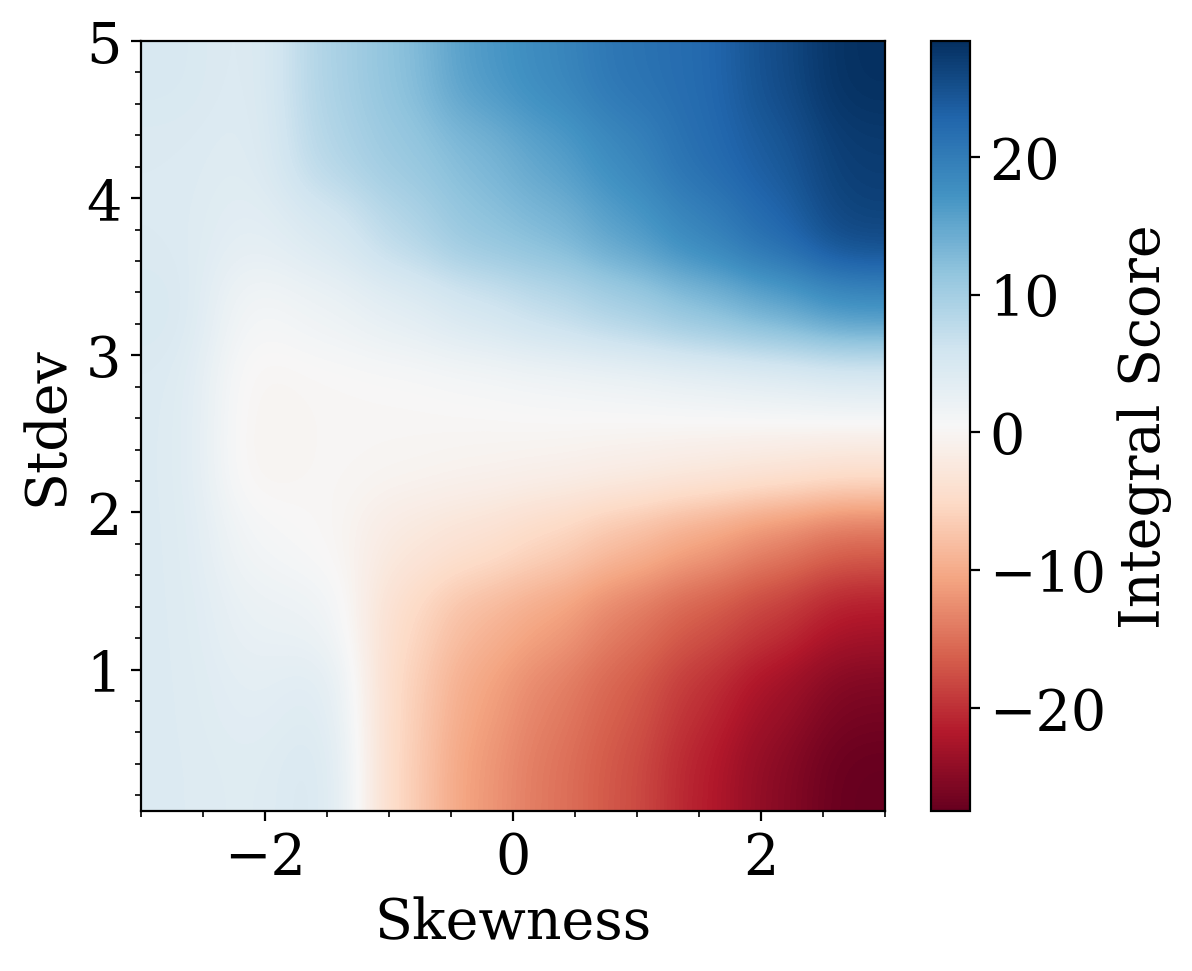

In [200]:
plt.figure(figsize=(6,5))
plt.imshow((Master), cmap='RdBu', extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], aspect='auto', 
          interpolation='Gaussian')
plt.colorbar(label='Integral Score')
plt.xlabel("Skewness")
plt.ylabel("Stdev")
plt.minorticks_on()

Text(-0.9, 16.01, 'Skew<0')

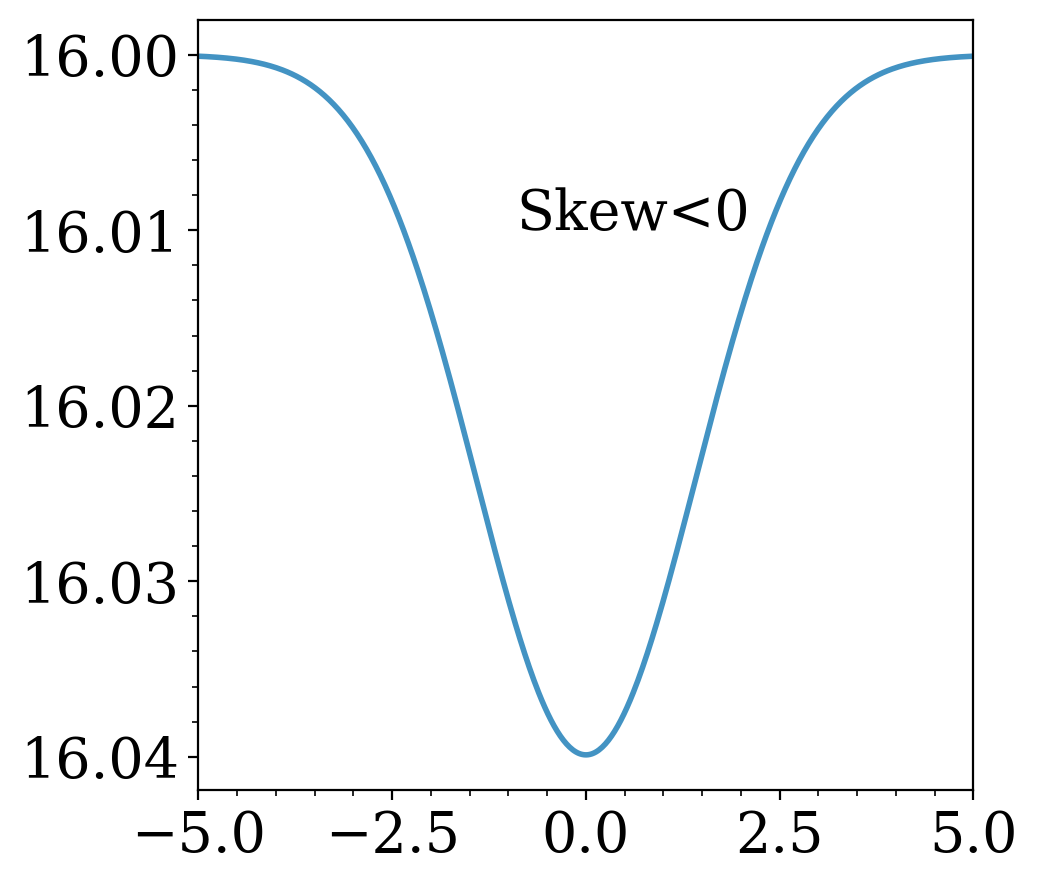

In [86]:
xx = np.linspace(-10, 10, 1000)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1)

plt.figure(figsize=(5,5))
plt.plot(xx, yy, color=cm(0.8), lw=2)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.text(-0.9, 16.01, "Skew<0")

Text(0.5, 0, 'Phase')

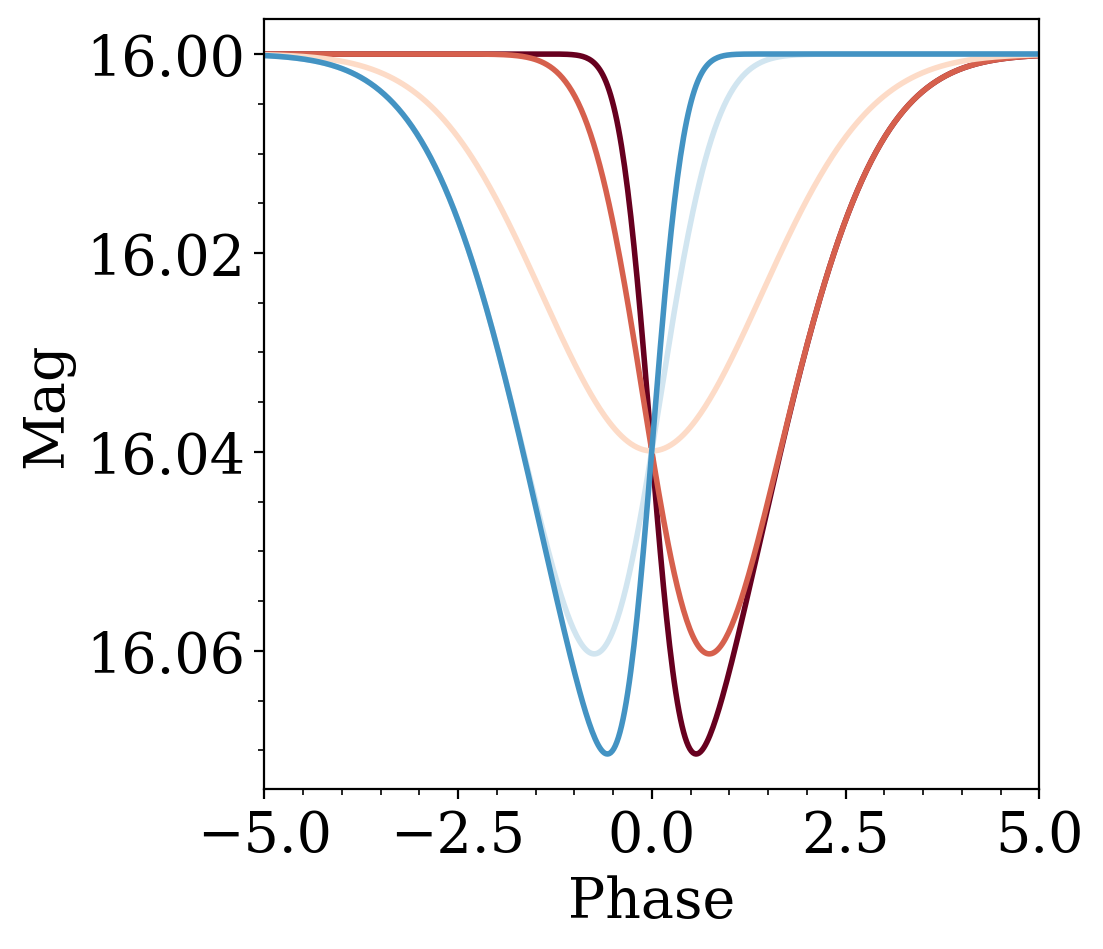

In [960]:
# fun plot 
xx = np.linspace(-10, 10, 1000)
ce = 0
plt.figure(figsize=(5,5))
for i in np.linspace(-3, 3, 5)[::-1]:
    yy = dip_models.skew_norm(xx, 0, 2, i, 16, 0.1)
    plt.plot(xx, yy, color=cm(ce), lw=2)
    ce += 0.2
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.ylabel("Mag")
plt.xlabel("Phase")

## Synthetic Observations

In [32]:
model = dip_models.skew_norm(time, np.median(time)+320, 15, -3, 16, 1) + np.random.normal(0, 0.001, len(time))
model_err = magerr

In [43]:
scr = []
for i in np.arange(-3, 3, step=0.25):
    model = dip_models.skew_norm(time, 
                                 np.median(time)+340,
                                 25, i, 16, 0.15) #
    model_err = 0.2*magerr

    tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

    tb['mjd'] = time
    tb['mag'] = model
    tb['magerr'] = model_err
    tb['flag'] = np.zeros(len(time))
    tb['band'] = ['r' for _ in range(len(time))]

    final = evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
            np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)
    scr.append(final.iloc[9])

{'assymetry_score': 395.7795107266872, 'left_error': 0.00310263094532, 'right_error': 3.403115186134597e-05, 'log_sum_error': 8.570701347318654, 'chi-square': 0.14145266244788846}
{'assymetry_score': 396.41217107264123, 'left_error': 0.0030961067331942865, 'right_error': 3.3342907686605207e-05, 'log_sum_error': 8.57516523621365, 'chi-square': 0.14273033028965024}
{'assymetry_score': 397.44739470655435, 'left_error': 0.003085413063639003, 'right_error': 3.2221921097405836e-05, 'log_sum_error': 8.582596406778807, 'chi-square': 0.14489467798425834}
{'assymetry_score': 399.04444252223544, 'left_error': 0.003068836627361609, 'right_error': 3.0499314568428076e-05, 'log_sum_error': 8.594433255042619, 'chi-square': 0.14844028107784654}
{'assymetry_score': 401.35161589820297, 'left_error': 0.0030446331743205443, 'right_error': 2.8015448754791575e-05, 'log_sum_error': 8.61250279701714, 'chi-square': 0.15409372610006128}
{'assymetry_score': 404.4380390497225, 'left_error': 0.0030114880357163024, 

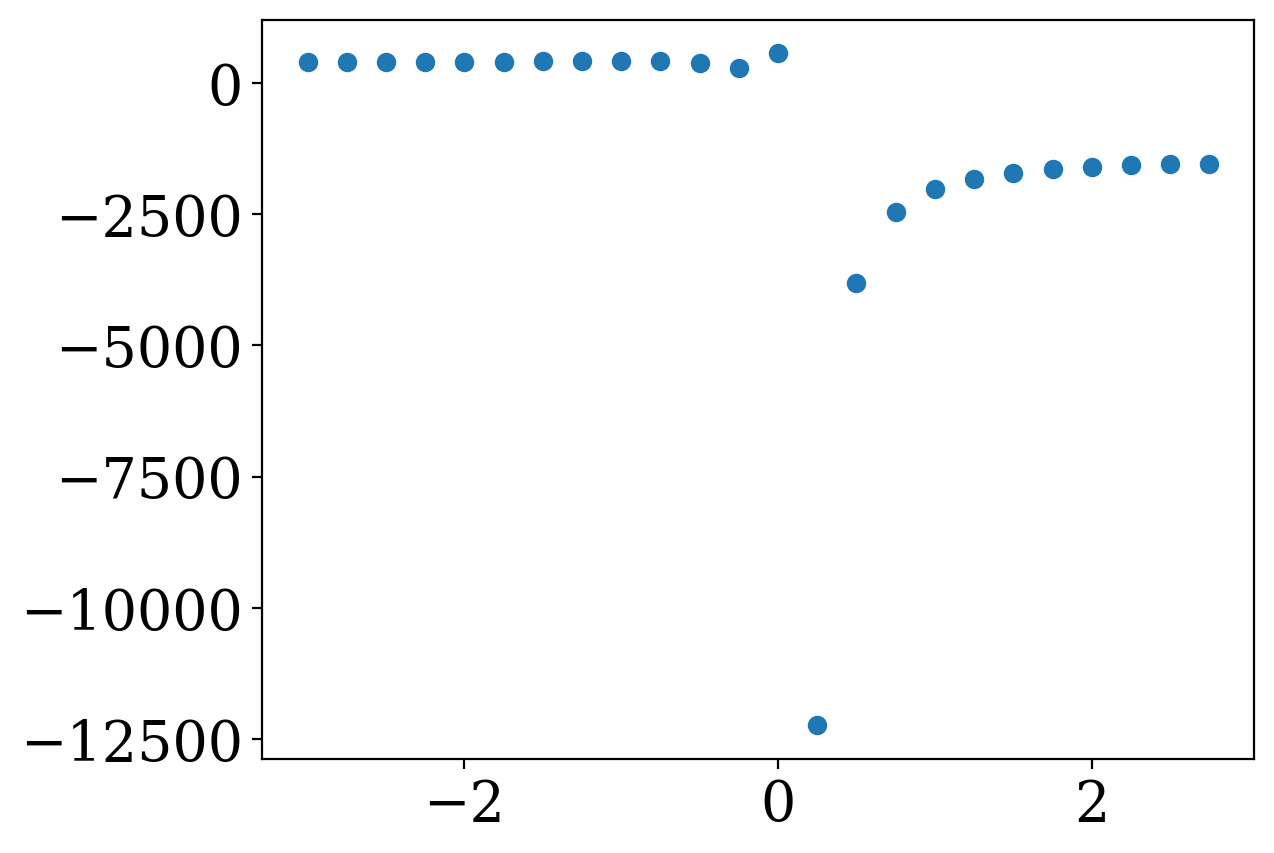

In [46]:
plt.scatter(np.arange(-3, 3, step=0.25), np.array(scr))

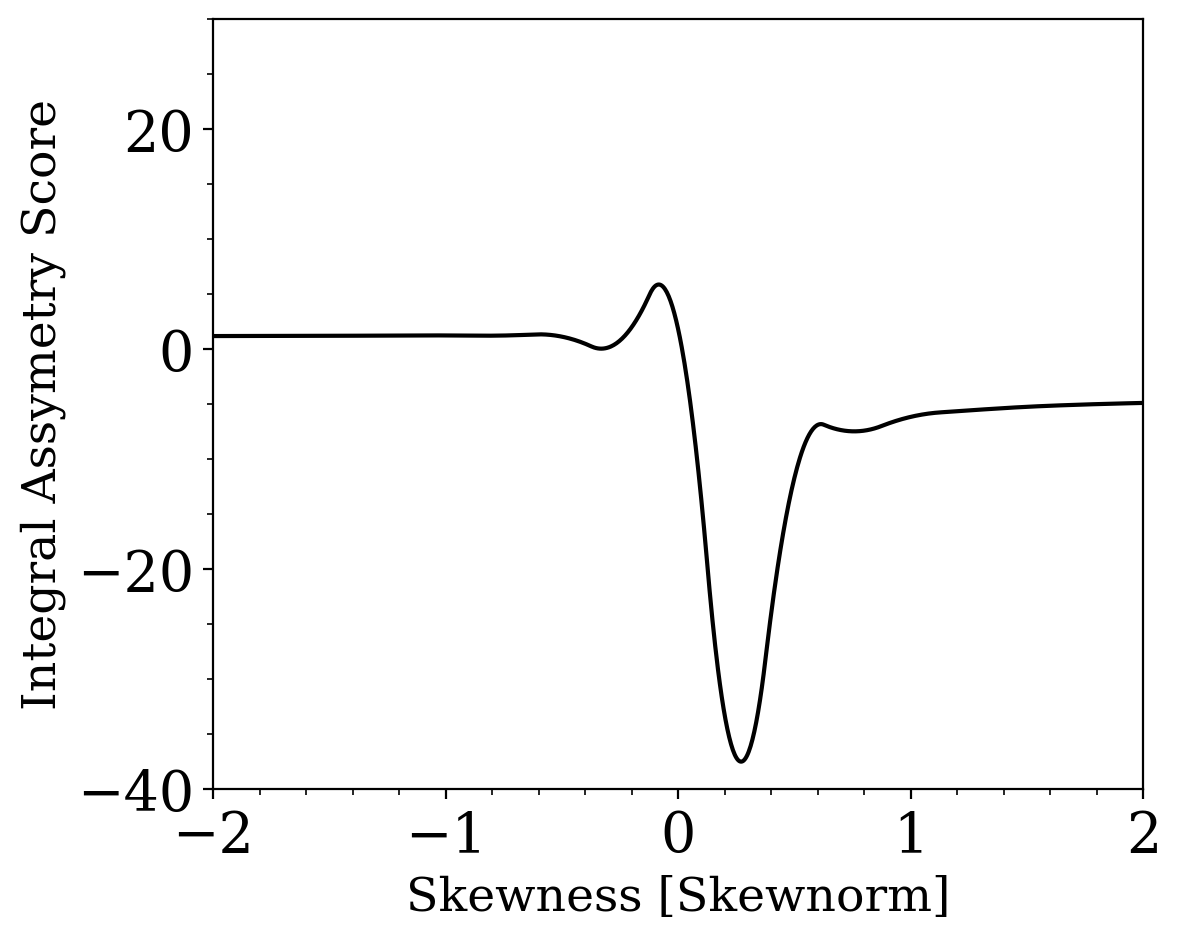

In [64]:
from scipy.interpolate import interp1d

plt.figure(figsize=(6,5))
f = interp1d(np.arange(-3, 3, step=0.25), (np.array(scr))/np.median(scr), kind='quadratic')
x1 = np.linspace(-2, 2, 1000)

plt.plot(x1, f(x1), color='k')
plt.xlim(-2, 2)
plt.ylim(-40, 30)

plt.ylabel("Integral Assymetry Score", fontsize=17)
plt.xlabel("Skewness [Skewnorm]", fontsize=17)
plt.minorticks_on()

Text(0.5, 1.0, 'Mock example')

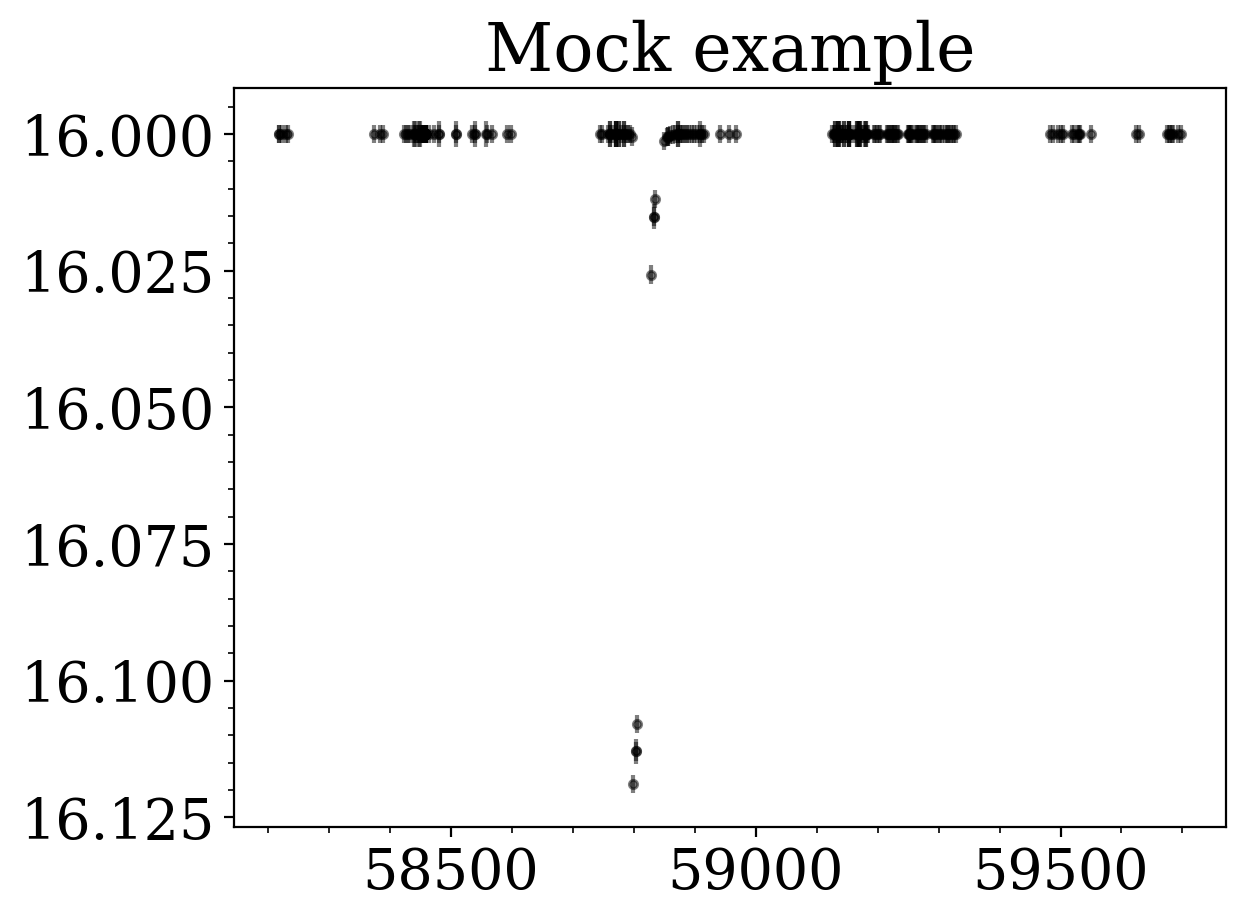

In [1009]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
#plt.xlim(np.median(time)+300-50, np.median(time)+300+50)

Text(0.5, 1.0, 'Mock example')

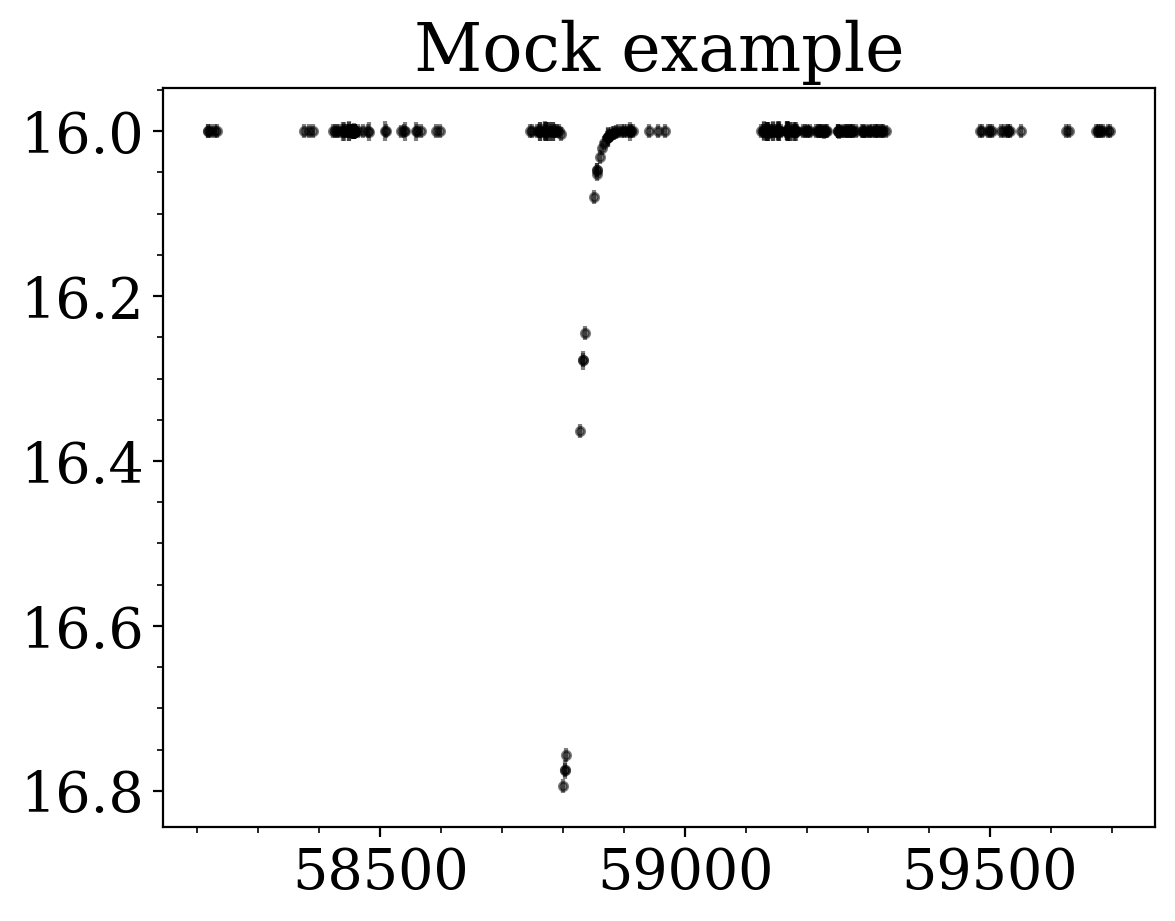

In [852]:
tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

In [853]:
tb['mjd'] = time
tb['mag'] = model
tb['magerr'] = model_err
tb['flag'] = np.zeros(len(time))
tb['band'] = ['r' for _ in range(len(time))]

In [854]:
evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
        np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)

{'assymetry_score': 163.72060606237912, 'left_error': 0.02711417888322459, 'right_error': 0.0013130027421399168, 'log_sum_error': 6.744194649155939, 'chi-square': 0.1535617365139034}


0         0.001037
1         0.019078
2         1.000000
3        68.490363
4     58776.476930
5     58783.498000
6     58598.145100
7         2.357344
8        15.000000
9       163.720606
10        0.153562
11       45.206441
12       18.010384
13       29.397590
14       18.249557
15     3436.372084
dtype: float64

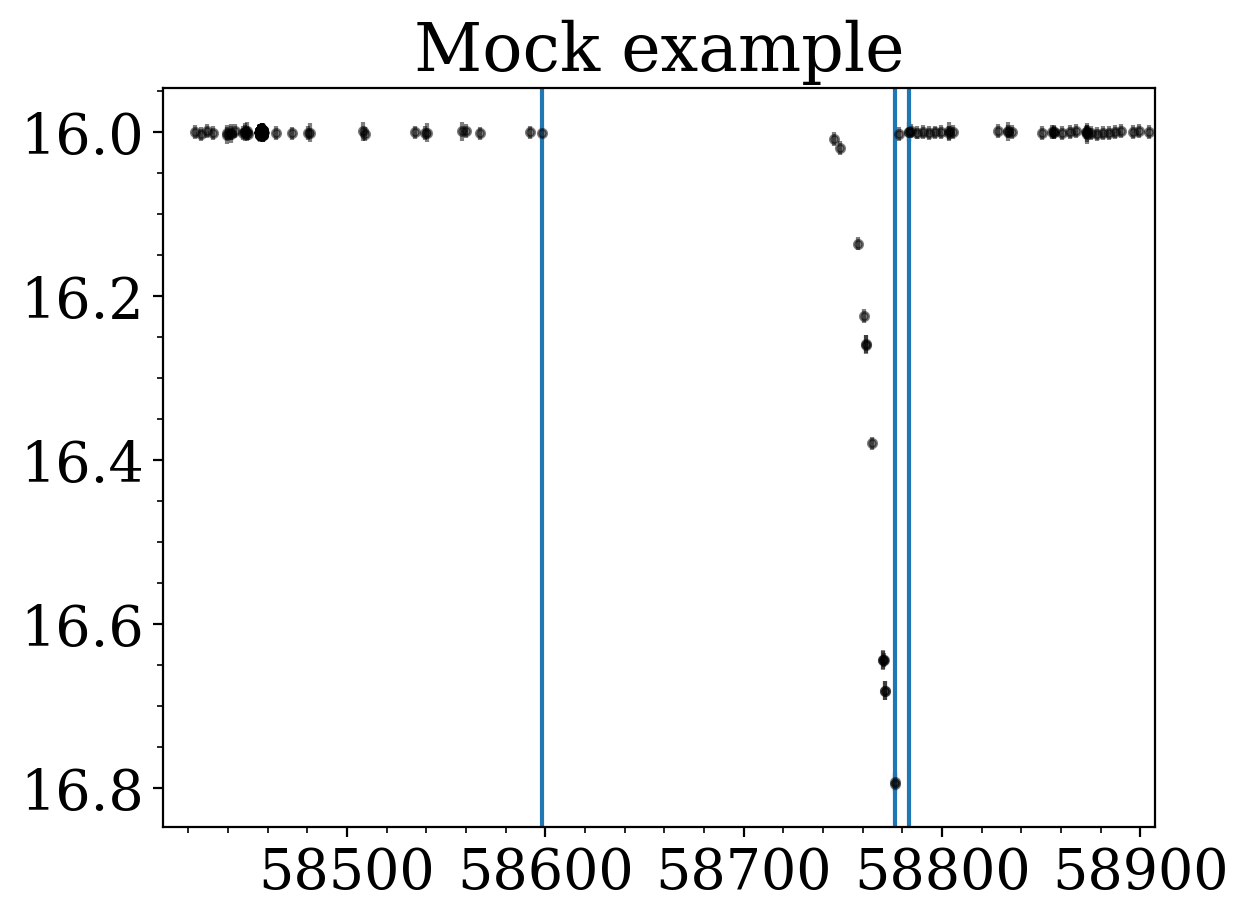

In [856]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
plt.xlim(np.median(time)+300-350, np.median(time)+300+150)
plt.axvline(58776.476930)
plt.axvline(58783.498000)
plt.axvline(58598.145100)

In [104]:
tbl = pd.read_parquet("/astro/users/atzanida/lrg_data/boyajiansearch/allsky/finalbatchv1.pq", engine='pyarrow')

In [121]:
for k in tbl.keys():
    print (k)

solution_id_gaia
designation_gaia
source_id_gaia
random_index_gaia
ref_epoch_gaia
ra_gaia
ra_error_gaia
dec_gaia
dec_error_gaia
parallax_gaia
parallax_error_gaia
parallax_over_error_gaia
pm_gaia
pmra_gaia
pmra_error_gaia
pmdec_gaia
pmdec_error_gaia
ra_dec_corr_gaia
ra_parallax_corr_gaia
ra_pmra_corr_gaia
ra_pmdec_corr_gaia
dec_parallax_corr_gaia
dec_pmra_corr_gaia
dec_pmdec_corr_gaia
parallax_pmra_corr_gaia
parallax_pmdec_corr_gaia
pmra_pmdec_corr_gaia
astrometric_n_obs_al_gaia
astrometric_n_obs_ac_gaia
astrometric_n_good_obs_al_gaia
astrometric_n_bad_obs_al_gaia
astrometric_gof_al_gaia
astrometric_chi2_al_gaia
astrometric_excess_noise_gaia
astrometric_excess_noise_sig_gaia
astrometric_params_solved_gaia
astrometric_primary_flag_gaia
nu_eff_used_in_astrometry_gaia
pseudocolour_gaia
pseudocolour_error_gaia
ra_pseudocolour_corr_gaia
dec_pseudocolour_corr_gaia
parallax_pseudocolour_corr_gaia
pmra_pseudocolour_corr_gaia
pmdec_pseudocolour_corr_gaia
astrometric_matched_transits_gaia
visibil

In [237]:
q = (tbl['Ndips']>0) & (tbl['integral_score']>250) & (~tbl['dip_cent'].duplicated())

In [284]:
tbl['dip_cent'].value_counts().values[0:10]

array([4766089,       9,       8,       7,       7,       6,       6,
             6,       6,       6])

In [353]:
count, bins = plt.np.histogram(tbl['dip_cent'][tbl['dip_cent']>0], 
            bins=np.arange(min(tbl['dip_cent'][tbl['dip_cent']>0]),
                           max(tbl['dip_cent']),
                           step=0.5))

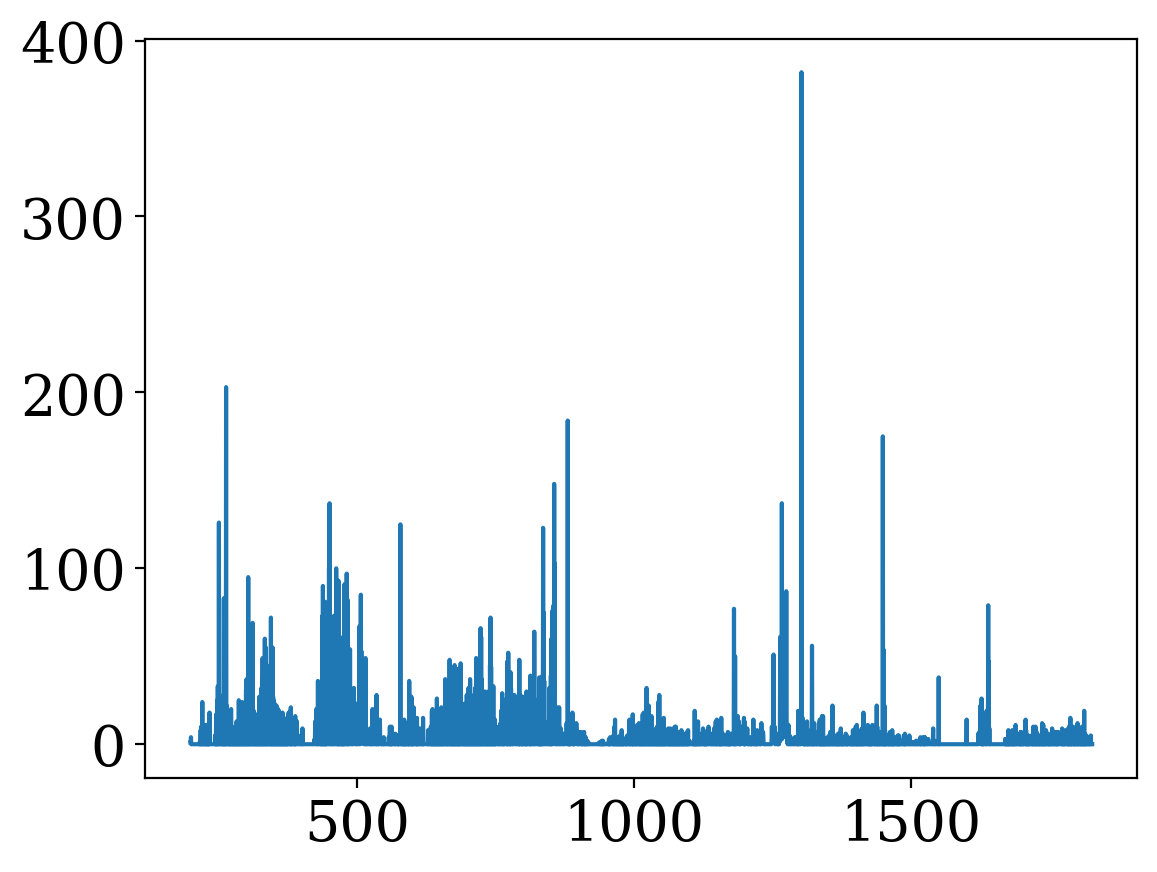

In [355]:
plt.plot(bins[1::]-58_000, count)

In [360]:
for i in range(0, len(count)):
    
    if count[i]>100:
        print (f"{bins[i+1]},")

58249.52098,
58262.52098,
58449.52098,
58577.52098,
58835.52098,
58855.52098,
58856.52098,
58880.02098,
59267.02098,
59302.52098,
59449.52098,


Text(0.5, 0, 'N$_{dips}$')

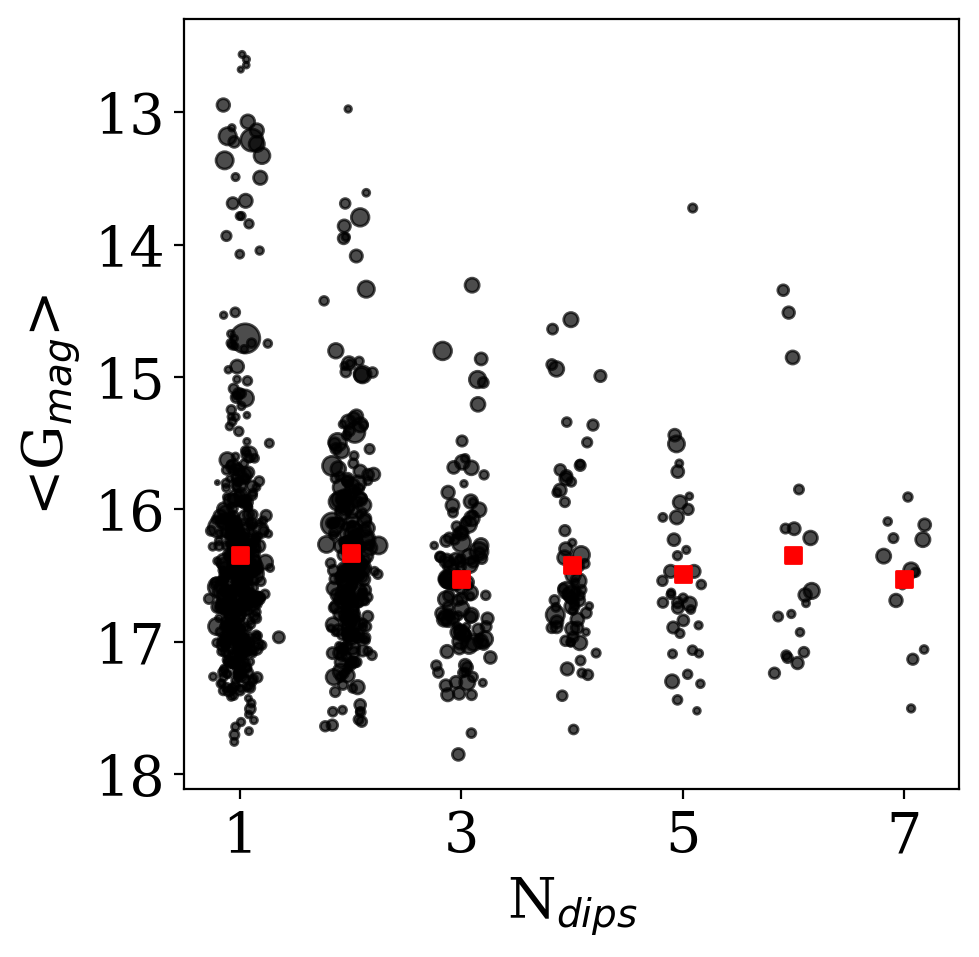

In [264]:
plt.figure(figsize=(5,5))
plt.scatter(tbl['Ndips'][q]+np.random.normal(0, 0.1, len(tbl['phot_g_mean_mag_gaia'][q])),
            tbl['phot_g_mean_mag_gaia'][q],
            s=tbl['best_dip_power'][q], 
           color='k', edgecolor='k', alpha=0.7)

for i in range(1, 9):
    qc = (tbl['Ndips']==i) & (tbl['integral_score']>250) & (~tbl['dip_cent'].duplicated())
        
    plt.scatter(i, np.mean(tbl['phot_g_mean_mag_gaia'][qc]), color='red', marker='s')


plt.ylim(plt.ylim()[::-1])
_ = plt.xticks(np.arange(1, 9, step=2))
plt.xlim(0.5, 7.5)
plt.ylabel("<G$_{mag}$>")
plt.xlabel("N$_{dips}$")

(18.11424525, 12.29972775)

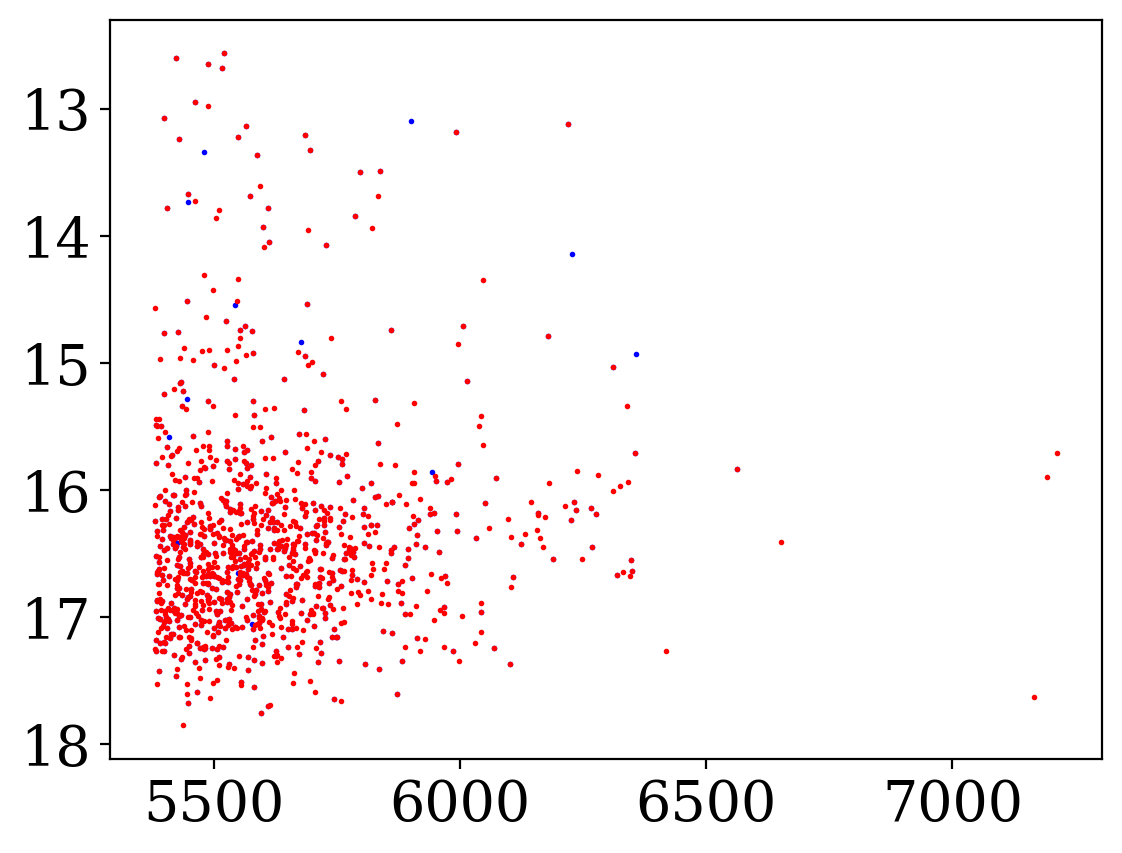

In [222]:
plt.scatter(tbl['teff_gspphot_gaia'][q2], (tbl['phot_g_mean_mag_gaia'][q2]), s=1, color='blue')
plt.scatter(tbl['teff_gspphot_gaia'][q], (tbl['phot_g_mean_mag_gaia'][q]), s=1, color='red')


plt.ylim(plt.ylim()[::-1])

Text(0, 0.5, 'Log(Dev)')

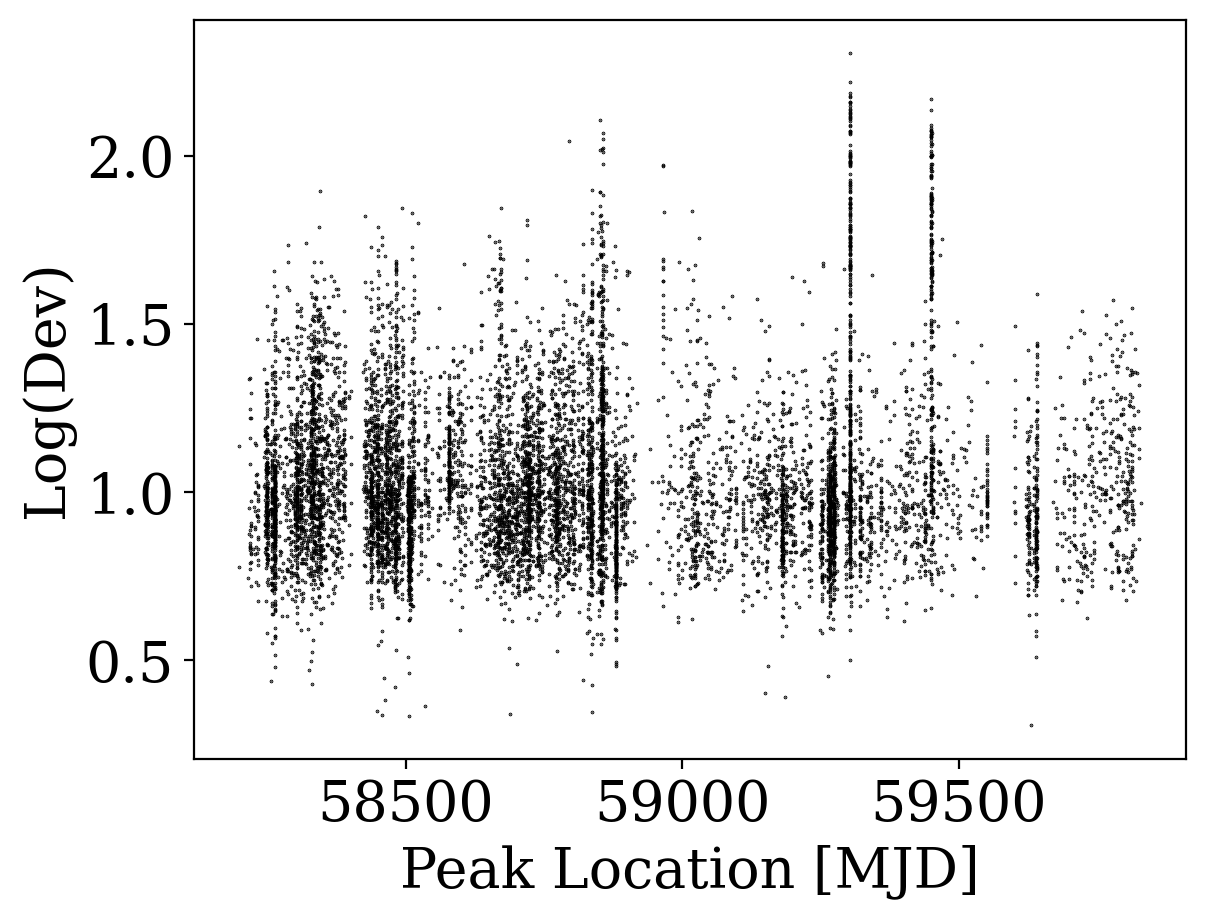

In [151]:
plt.scatter(tbl['dip_cent'][q], np.log10(tbl['best_dip_power'][q]), s=0.1, color='k')
plt.xlabel("Peak Location [MJD]")
plt.ylabel("Log(Dev)")

Text(0, 0.5, 'N$_{{stars}}$')

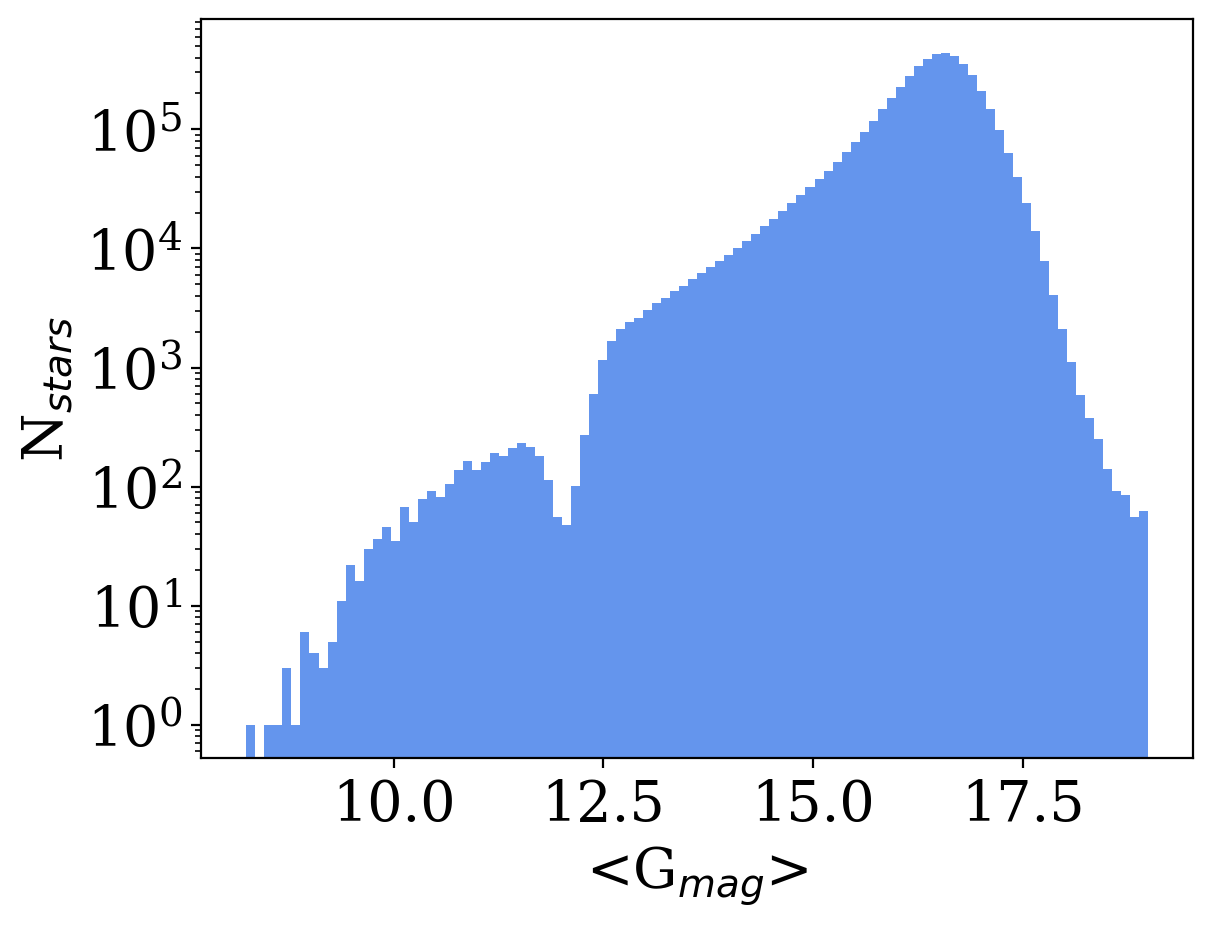

In [118]:
_ = plt.hist(tbl['phot_g_mean_mag_gaia'], bins=100, color='cornflowerblue')
plt.yscale('log')
plt.xlabel("<G$_{mag}$>")
plt.ylabel("N$_{{stars}}$")

In [119]:
tbl.head(2)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,best_dip_power,best_dip_frac1sig,loc_dip_back,loc_dip_forward,dip_cent,integral_score,gp_logsum_err,left_integral_error,right_integral_error,len_in_window
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10595126476800,1636148068921376768,Gaia DR3 5291399870976,5291399870976,651594654,2016.0,44.920804,0.056823,0.146074,0.048966,0.379842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16507971043328,1636148068921376768,Gaia DR3 8250632981888,8250632981888,308268319,2016.0,44.998582,0.073726,0.230765,0.061019,0.734424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
